In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import optuna 

import missingno as msno

sns.set()

In [2]:
features = pd.read_csv('../data/processed/features.csv')
app_train_sample = pd.read_csv('../data/raw/application_train.csv', nrows=1)

In [3]:
categ_var = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE']

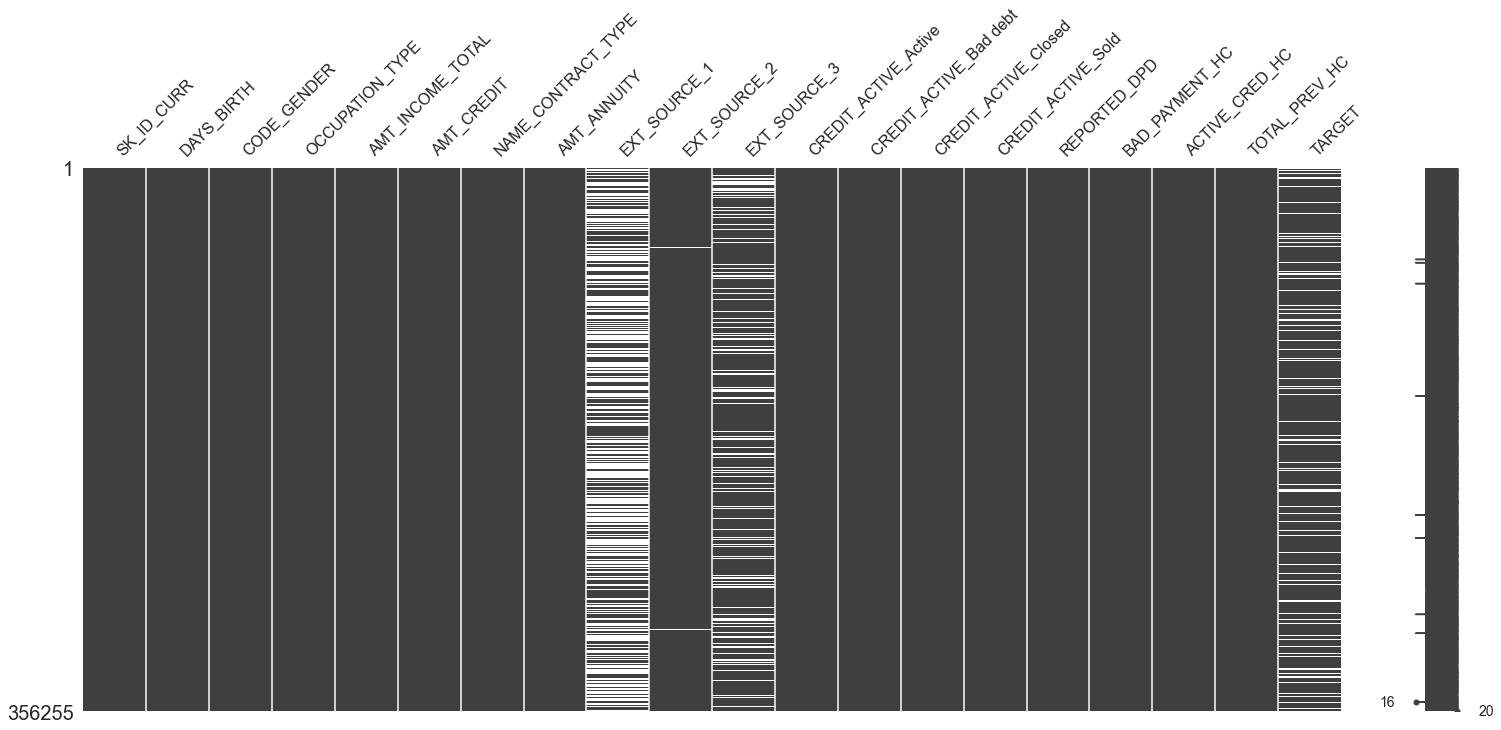

In [4]:
msno.matrix(features)

In [5]:
for col in features.columns:
    if col not in app_train_sample.columns:
        features[col].fillna(0, inplace=True)

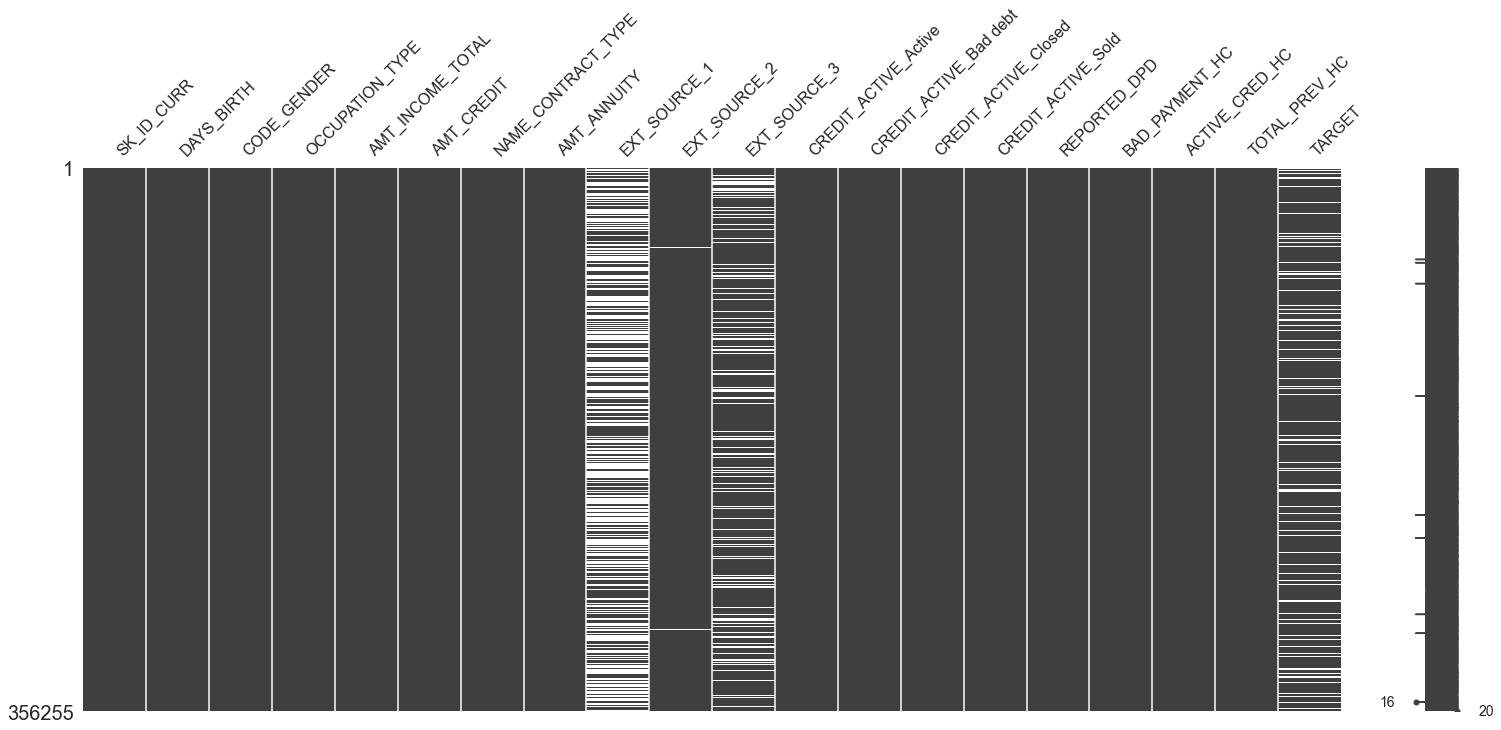

In [6]:
msno.matrix(features)

In [7]:
train = features[features['TARGET'].notna()].copy()
test = features[features['TARGET'].isna()].copy()
target = train['TARGET']
train.drop(columns=['TARGET'], inplace=True)
test.drop(columns=['TARGET'], inplace=True)

imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))
imputer.fit(train)
scaler.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

train = scaler.transform(train)
test = scaler.transform(test)

features_names = list(features.drop(columns=['TARGET']).columns)

print(f'train set shape : {train.shape}')
print(f'test set shape : {test.shape}')

train set shape : (307511, 19)
test set shape : (48744, 19)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(train, target) 

In [9]:
train_data = lgb.Dataset(X_train, label=y_train, feature_name=features_names)
test_data = lgb.Dataset(X_test, label=y_test, feature_name=features_names, reference=train_data)

In [10]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    evals_results = dict()
    
    bst = lgb.train(param, train_data, verbose_eval=1, evals_result=evals_results,
                    valid_sets=[train_data, test_data], early_stopping_rounds=30)
    return bst.best_score['valid_1']['auc']

In [11]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[1]	training's auc: 0.725665	valid_1's auc: 0.715935
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731667	valid_1's auc: 0.717154
[3]	training's auc: 0.743045	valid_1's auc: 0.72657
[4]	training's auc: 0.746576	valid_1's auc: 0.729108
[5]	training's auc: 0.747887	valid_1's auc: 0.730266
[6]	training's auc: 0.749258	valid_1's auc: 0.731163
[7]	training's auc: 0.752603	valid_1's auc: 0.732094
[8]	training's auc: 0.754601	valid_1's auc: 0.732385
[9]	training's auc: 0.757314	valid_1's auc: 0.733905
[10]	training's auc: 0.761747	valid_1's auc: 0.73622
[11]	training's auc: 0.763246	valid_1's auc: 0.737247
[12]	training's auc: 0.765874	valid_1's auc: 0.738223
[13]	training's auc: 0.767793	valid_1's auc: 0.738583
[14]	training's auc: 0.768717	valid_1's auc: 0.739208
[15]	training's auc: 0.769788	valid_1's auc: 0.739582
[16]	training's auc: 0.771175	valid_1's auc: 0.739467
[17]	training's auc: 0.772429	valid_1's auc: 0.739573
[18]	training's auc: 0.774116	va

[I 2020-06-11 18:07:32,362] Finished trial#0 with value: 0.7427549638437327 with parameters: {'lambda_l1': 0.0031313548734852167, 'lambda_l2': 2.6475138444671374e-08, 'num_leaves': 129, 'feature_fraction': 0.6146896040057072, 'bagging_fraction': 0.950258784309922, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial#0 with value: 0.7427549638437327.


[1]	training's auc: 0.722413	valid_1's auc: 0.714077
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.728351	valid_1's auc: 0.717069
[3]	training's auc: 0.738288	valid_1's auc: 0.726326
[4]	training's auc: 0.741108	valid_1's auc: 0.728606
[5]	training's auc: 0.742448	valid_1's auc: 0.729627
[6]	training's auc: 0.743922	valid_1's auc: 0.730548
[7]	training's auc: 0.745947	valid_1's auc: 0.731297
[8]	training's auc: 0.7475	valid_1's auc: 0.731875
[9]	training's auc: 0.749768	valid_1's auc: 0.733934
[10]	training's auc: 0.752951	valid_1's auc: 0.735603
[11]	training's auc: 0.753752	valid_1's auc: 0.736149
[12]	training's auc: 0.755387	valid_1's auc: 0.737044
[13]	training's auc: 0.756708	valid_1's auc: 0.737281
[14]	training's auc: 0.757636	valid_1's auc: 0.737934
[15]	training's auc: 0.758261	valid_1's auc: 0.738173
[16]	training's auc: 0.759391	valid_1's auc: 0.738314
[17]	training's auc: 0.760303	valid_1's auc: 0.738218
[18]	training's auc: 0.761521	va

[I 2020-06-11 18:07:36,847] Finished trial#1 with value: 0.7429672100695585 with parameters: {'lambda_l1': 0.00024943175102206663, 'lambda_l2': 0.13961034422354573, 'num_leaves': 84, 'feature_fraction': 0.6214983879680505, 'bagging_fraction': 0.773002247223344, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.732619	valid_1's auc: 0.714094
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.741791	valid_1's auc: 0.715999
[3]	training's auc: 0.754834	valid_1's auc: 0.725548
[4]	training's auc: 0.759247	valid_1's auc: 0.729547
[5]	training's auc: 0.761768	valid_1's auc: 0.730894
[6]	training's auc: 0.763999	valid_1's auc: 0.732214
[7]	training's auc: 0.76752	valid_1's auc: 0.732825
[8]	training's auc: 0.770142	valid_1's auc: 0.733411
[9]	training's auc: 0.773213	valid_1's auc: 0.735048
[10]	training's auc: 0.777483	valid_1's auc: 0.736786
[11]	training's auc: 0.779349	valid_1's auc: 0.737283
[12]	training's auc: 0.782718	valid_1's auc: 0.738502
[13]	training's auc: 0.785746	valid_1's auc: 0.738685
[14]	training's auc: 0.787292	valid_1's auc: 0.739185
[15]	training's auc: 0.788855	valid_1's auc: 0.739754
[16]	training's auc: 0.790873	valid_1's auc: 0.739935
[17]	training's auc: 0.792725	valid_1's auc: 0.739649
[18]	training's auc: 0.794639	v

[I 2020-06-11 18:07:42,357] Finished trial#2 with value: 0.7415311586449678 with parameters: {'lambda_l1': 7.237044840155535e-05, 'lambda_l2': 1.4103166918234271, 'num_leaves': 236, 'feature_fraction': 0.6334811848947274, 'bagging_fraction': 0.840652558027104, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.719657	valid_1's auc: 0.715337
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722145	valid_1's auc: 0.713509
[3]	training's auc: 0.729161	valid_1's auc: 0.72069
[4]	training's auc: 0.732057	valid_1's auc: 0.723378
[5]	training's auc: 0.733028	valid_1's auc: 0.725034
[6]	training's auc: 0.734385	valid_1's auc: 0.726093
[7]	training's auc: 0.735913	valid_1's auc: 0.726685
[8]	training's auc: 0.737692	valid_1's auc: 0.728091
[9]	training's auc: 0.740268	valid_1's auc: 0.729926
[10]	training's auc: 0.743651	valid_1's auc: 0.732393
[11]	training's auc: 0.745323	valid_1's auc: 0.733991
[12]	training's auc: 0.747493	valid_1's auc: 0.734972
[13]	training's auc: 0.748403	valid_1's auc: 0.734948
[14]	training's auc: 0.74917	valid_1's auc: 0.73515
[15]	training's auc: 0.749779	valid_1's auc: 0.735394
[16]	training's auc: 0.750177	valid_1's auc: 0.735685
[17]	training's auc: 0.751136	valid_1's auc: 0.736107
[18]	training's auc: 0.752086	val

[I 2020-06-11 18:07:46,347] Finished trial#3 with value: 0.7425319381478833 with parameters: {'lambda_l1': 0.10319411947671009, 'lambda_l2': 1.1788280887134583e-05, 'num_leaves': 60, 'feature_fraction': 0.8562204751890318, 'bagging_fraction': 0.6221339814727931, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.695196	valid_1's auc: 0.685185
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732505	valid_1's auc: 0.716379
[3]	training's auc: 0.737559	valid_1's auc: 0.716686
[4]	training's auc: 0.749556	valid_1's auc: 0.730167
[5]	training's auc: 0.751827	valid_1's auc: 0.731935
[6]	training's auc: 0.751946	valid_1's auc: 0.730847
[7]	training's auc: 0.75649	valid_1's auc: 0.733996
[8]	training's auc: 0.759076	valid_1's auc: 0.735148
[9]	training's auc: 0.761677	valid_1's auc: 0.735253
[10]	training's auc: 0.76351	valid_1's auc: 0.734592
[11]	training's auc: 0.764625	valid_1's auc: 0.735585
[12]	training's auc: 0.766872	valid_1's auc: 0.736442
[13]	training's auc: 0.76864	valid_1's auc: 0.736473
[14]	training's auc: 0.770232	valid_1's auc: 0.737408
[15]	training's auc: 0.771651	valid_1's auc: 0.738683
[16]	training's auc: 0.773526	valid_1's auc: 0.739305
[17]	training's auc: 0.774868	valid_1's auc: 0.7392
[18]	training's auc: 0.775989	valid

[I 2020-06-11 18:07:49,484] Finished trial#4 with value: 0.7427142221327707 with parameters: {'lambda_l1': 3.414070459245143e-07, 'lambda_l2': 5.8069858157397155e-08, 'num_leaves': 134, 'feature_fraction': 0.5277091167244768, 'bagging_fraction': 0.7726584838387202, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.705214	valid_1's auc: 0.682676
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.741732	valid_1's auc: 0.714017
[3]	training's auc: 0.746559	valid_1's auc: 0.714382
[4]	training's auc: 0.758927	valid_1's auc: 0.72823
[5]	training's auc: 0.759933	valid_1's auc: 0.729227
[6]	training's auc: 0.761027	valid_1's auc: 0.729342
[7]	training's auc: 0.766205	valid_1's auc: 0.732652
[8]	training's auc: 0.76978	valid_1's auc: 0.733635
[9]	training's auc: 0.772207	valid_1's auc: 0.733544
[10]	training's auc: 0.77439	valid_1's auc: 0.733478
[11]	training's auc: 0.775763	valid_1's auc: 0.734438
[12]	training's auc: 0.777388	valid_1's auc: 0.734613
[13]	training's auc: 0.779639	valid_1's auc: 0.734463
[14]	training's auc: 0.781695	valid_1's auc: 0.736485
[15]	training's auc: 0.7833	valid_1's auc: 0.737577
[16]	training's auc: 0.785091	valid_1's auc: 0.738228
[17]	training's auc: 0.786564	valid_1's auc: 0.738569
[18]	training's auc: 0.788706	valid

[I 2020-06-11 18:07:52,483] Finished trial#5 with value: 0.7408297328111852 with parameters: {'lambda_l1': 1.6455808810433576e-07, 'lambda_l2': 1.9290875267126395, 'num_leaves': 220, 'feature_fraction': 0.539718446462222, 'bagging_fraction': 0.6891912377422953, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.700567	valid_1's auc: 0.683016
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73852	valid_1's auc: 0.714237
[3]	training's auc: 0.743059	valid_1's auc: 0.713403
[4]	training's auc: 0.755758	valid_1's auc: 0.727765
[5]	training's auc: 0.756859	valid_1's auc: 0.72859
[6]	training's auc: 0.758594	valid_1's auc: 0.728535
[7]	training's auc: 0.764324	valid_1's auc: 0.73181
[8]	training's auc: 0.768609	valid_1's auc: 0.732918
[9]	training's auc: 0.771774	valid_1's auc: 0.732956
[10]	training's auc: 0.774137	valid_1's auc: 0.733115
[11]	training's auc: 0.77593	valid_1's auc: 0.73382
[12]	training's auc: 0.777854	valid_1's auc: 0.734213
[13]	training's auc: 0.780319	valid_1's auc: 0.733652
[14]	training's auc: 0.782776	valid_1's auc: 0.73538
[15]	training's auc: 0.78447	valid_1's auc: 0.735957
[16]	training's auc: 0.786048	valid_1's auc: 0.736653
[17]	training's auc: 0.787965	valid_1's auc: 0.736723
[18]	training's auc: 0.790324	valid_1

[I 2020-06-11 18:07:56,056] Finished trial#6 with value: 0.7387251808272749 with parameters: {'lambda_l1': 2.3395428049878747e-06, 'lambda_l2': 0.0022544677774679394, 'num_leaves': 220, 'feature_fraction': 0.5592923388279896, 'bagging_fraction': 0.6922414150120677, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.696678	valid_1's auc: 0.680437
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.736164	valid_1's auc: 0.712345
[3]	training's auc: 0.741716	valid_1's auc: 0.710931
[4]	training's auc: 0.755274	valid_1's auc: 0.725336
[5]	training's auc: 0.758525	valid_1's auc: 0.727895
[6]	training's auc: 0.760561	valid_1's auc: 0.727268
[7]	training's auc: 0.766027	valid_1's auc: 0.730105
[8]	training's auc: 0.770155	valid_1's auc: 0.731177
[9]	training's auc: 0.773376	valid_1's auc: 0.731302
[10]	training's auc: 0.775929	valid_1's auc: 0.730623
[11]	training's auc: 0.77808	valid_1's auc: 0.73214
[12]	training's auc: 0.78119	valid_1's auc: 0.733107
[13]	training's auc: 0.78393	valid_1's auc: 0.733196
[14]	training's auc: 0.7857	valid_1's auc: 0.733415
[15]	training's auc: 0.787891	valid_1's auc: 0.735312
[16]	training's auc: 0.790562	valid_1's auc: 0.735249
[17]	training's auc: 0.793164	valid_1's auc: 0.73541
[18]	training's auc: 0.794888	valid_1

[I 2020-06-11 18:07:59,440] Finished trial#7 with value: 0.7396187662758972 with parameters: {'lambda_l1': 1.7316467134751208e-05, 'lambda_l2': 0.00975566418360451, 'num_leaves': 235, 'feature_fraction': 0.5049312827160254, 'bagging_fraction': 0.6742365050639678, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial#1 with value: 0.7429672100695585.


[1]	training's auc: 0.727089	valid_1's auc: 0.71504
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733843	valid_1's auc: 0.716713
[3]	training's auc: 0.746204	valid_1's auc: 0.726951
[4]	training's auc: 0.748167	valid_1's auc: 0.728363
[5]	training's auc: 0.750475	valid_1's auc: 0.729687
[6]	training's auc: 0.752093	valid_1's auc: 0.731029
[7]	training's auc: 0.755941	valid_1's auc: 0.732415
[8]	training's auc: 0.758616	valid_1's auc: 0.733122
[9]	training's auc: 0.761108	valid_1's auc: 0.734703
[10]	training's auc: 0.764675	valid_1's auc: 0.736429
[11]	training's auc: 0.76582	valid_1's auc: 0.736782
[12]	training's auc: 0.768601	valid_1's auc: 0.737849
[13]	training's auc: 0.769724	valid_1's auc: 0.738106
[14]	training's auc: 0.770863	valid_1's auc: 0.7387
[15]	training's auc: 0.771974	valid_1's auc: 0.73905
[16]	training's auc: 0.773629	valid_1's auc: 0.739084
[17]	training's auc: 0.775562	valid_1's auc: 0.738959
[18]	training's auc: 0.777592	valid

[I 2020-06-11 18:08:04,306] Finished trial#8 with value: 0.7430493641936444 with parameters: {'lambda_l1': 1.9664256593158766e-05, 'lambda_l2': 5.063123875565174e-07, 'num_leaves': 147, 'feature_fraction': 0.6750749161136727, 'bagging_fraction': 0.9258006021699938, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial#8 with value: 0.7430493641936444.


[1]	training's auc: 0.661964	valid_1's auc: 0.661231
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.713435	valid_1's auc: 0.711649
[3]	training's auc: 0.717505	valid_1's auc: 0.714735
[4]	training's auc: 0.722318	valid_1's auc: 0.719731
[5]	training's auc: 0.722698	valid_1's auc: 0.720777
[6]	training's auc: 0.72035	valid_1's auc: 0.719138
[7]	training's auc: 0.725938	valid_1's auc: 0.723585
[8]	training's auc: 0.727327	valid_1's auc: 0.724398
[9]	training's auc: 0.729106	valid_1's auc: 0.725647
[10]	training's auc: 0.729677	valid_1's auc: 0.725927
[11]	training's auc: 0.729654	valid_1's auc: 0.72632
[12]	training's auc: 0.730806	valid_1's auc: 0.727241
[13]	training's auc: 0.731676	valid_1's auc: 0.728243
[14]	training's auc: 0.73138	valid_1's auc: 0.728136
[15]	training's auc: 0.730808	valid_1's auc: 0.727989
[16]	training's auc: 0.731626	valid_1's auc: 0.72883
[17]	training's auc: 0.732048	valid_1's auc: 0.728768
[18]	training's auc: 0.731574	vali

[I 2020-06-11 18:08:07,824] Finished trial#9 with value: 0.7413653562469448 with parameters: {'lambda_l1': 4.1763889837799875, 'lambda_l2': 0.00016883881649269454, 'num_leaves': 8, 'feature_fraction': 0.45190448549278855, 'bagging_fraction': 0.8431087098780308, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial#8 with value: 0.7430493641936444.


[1]	training's auc: 0.719329	valid_1's auc: 0.709699
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.72532	valid_1's auc: 0.70839
[3]	training's auc: 0.733703	valid_1's auc: 0.71816
[4]	training's auc: 0.738511	valid_1's auc: 0.720536
[5]	training's auc: 0.741134	valid_1's auc: 0.722505
[6]	training's auc: 0.744748	valid_1's auc: 0.724576
[7]	training's auc: 0.748934	valid_1's auc: 0.725687
[8]	training's auc: 0.752009	valid_1's auc: 0.725854
[9]	training's auc: 0.755557	valid_1's auc: 0.727888
[10]	training's auc: 0.759597	valid_1's auc: 0.729509
[11]	training's auc: 0.762517	valid_1's auc: 0.731185
[12]	training's auc: 0.765618	valid_1's auc: 0.731532
[13]	training's auc: 0.76782	valid_1's auc: 0.732024
[14]	training's auc: 0.769506	valid_1's auc: 0.731473
[15]	training's auc: 0.771274	valid_1's auc: 0.732028
[16]	training's auc: 0.774008	valid_1's auc: 0.731956
[17]	training's auc: 0.775953	valid_1's auc: 0.731999
[18]	training's auc: 0.77805	valid

[I 2020-06-11 18:08:11,360] Finished trial#10 with value: 0.7325654705456184 with parameters: {'lambda_l1': 0.008759220828843964, 'lambda_l2': 1.3448969819238938e-06, 'num_leaves': 175, 'feature_fraction': 0.7957082579633188, 'bagging_fraction': 0.42746933969825635, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial#8 with value: 0.7430493641936444.


[1]	training's auc: 0.723031	valid_1's auc: 0.71706
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.726532	valid_1's auc: 0.715932
[3]	training's auc: 0.733504	valid_1's auc: 0.722384
[4]	training's auc: 0.736165	valid_1's auc: 0.724831
[5]	training's auc: 0.737128	valid_1's auc: 0.725721
[6]	training's auc: 0.738548	valid_1's auc: 0.726434
[7]	training's auc: 0.741154	valid_1's auc: 0.727932
[8]	training's auc: 0.74288	valid_1's auc: 0.728988
[9]	training's auc: 0.746044	valid_1's auc: 0.731659
[10]	training's auc: 0.749235	valid_1's auc: 0.733981
[11]	training's auc: 0.750975	valid_1's auc: 0.735435
[12]	training's auc: 0.753337	valid_1's auc: 0.737168
[13]	training's auc: 0.75404	valid_1's auc: 0.737191
[14]	training's auc: 0.75456	valid_1's auc: 0.73749
[15]	training's auc: 0.755088	valid_1's auc: 0.737475
[16]	training's auc: 0.756059	valid_1's auc: 0.737486
[17]	training's auc: 0.757184	valid_1's auc: 0.73771
[18]	training's auc: 0.758382	valid_

[I 2020-06-11 18:08:16,652] Finished trial#11 with value: 0.7440751732906039 with parameters: {'lambda_l1': 0.00022378309690311647, 'lambda_l2': 0.18661135227495784, 'num_leaves': 74, 'feature_fraction': 0.730597860896908, 'bagging_fraction': 0.9926024378908509, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial#11 with value: 0.7440751732906039.


[1]	training's auc: 0.721912	valid_1's auc: 0.715931
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.72607	valid_1's auc: 0.716426
[3]	training's auc: 0.732676	valid_1's auc: 0.722413
[4]	training's auc: 0.735925	valid_1's auc: 0.725394
[5]	training's auc: 0.736975	valid_1's auc: 0.72599
[6]	training's auc: 0.737755	valid_1's auc: 0.726354
[7]	training's auc: 0.740583	valid_1's auc: 0.727462
[8]	training's auc: 0.742189	valid_1's auc: 0.728214
[9]	training's auc: 0.745648	valid_1's auc: 0.731242
[10]	training's auc: 0.748879	valid_1's auc: 0.733306
[11]	training's auc: 0.750538	valid_1's auc: 0.73519
[12]	training's auc: 0.752908	valid_1's auc: 0.736965
[13]	training's auc: 0.753547	valid_1's auc: 0.737199
[14]	training's auc: 0.753998	valid_1's auc: 0.73702
[15]	training's auc: 0.754706	valid_1's auc: 0.737305
[16]	training's auc: 0.755859	valid_1's auc: 0.737175
[17]	training's auc: 0.756886	valid_1's auc: 0.737339
[18]	training's auc: 0.758091	vali

[I 2020-06-11 18:08:21,038] Finished trial#12 with value: 0.7441475241378818 with parameters: {'lambda_l1': 8.625922761960851e-06, 'lambda_l2': 9.794722285916647e-07, 'num_leaves': 72, 'feature_fraction': 0.7536374487109213, 'bagging_fraction': 0.9836950709220884, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial#12 with value: 0.7441475241378818.


[1]	training's auc: 0.720259	valid_1's auc: 0.713979
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.72709	valid_1's auc: 0.717288
[3]	training's auc: 0.731073	valid_1's auc: 0.721505
[4]	training's auc: 0.734134	valid_1's auc: 0.724412
[5]	training's auc: 0.73502	valid_1's auc: 0.724857
[6]	training's auc: 0.736243	valid_1's auc: 0.726435
[7]	training's auc: 0.738027	valid_1's auc: 0.72738
[8]	training's auc: 0.739433	valid_1's auc: 0.728496
[9]	training's auc: 0.740292	valid_1's auc: 0.728838
[10]	training's auc: 0.742265	valid_1's auc: 0.730424
[11]	training's auc: 0.743267	valid_1's auc: 0.730983
[12]	training's auc: 0.744297	valid_1's auc: 0.731608
[13]	training's auc: 0.745087	valid_1's auc: 0.731768
[14]	training's auc: 0.746016	valid_1's auc: 0.732328
[15]	training's auc: 0.746966	valid_1's auc: 0.732763
[16]	training's auc: 0.747937	valid_1's auc: 0.733369
[17]	training's auc: 0.748968	valid_1's auc: 0.733625
[18]	training's auc: 0.750084	val

[I 2020-06-11 18:08:25,908] Finished trial#13 with value: 0.7441506387684703 with parameters: {'lambda_l1': 3.0662130780871894e-08, 'lambda_l2': 6.432955156367249e-05, 'num_leaves': 57, 'feature_fraction': 0.9713835003955533, 'bagging_fraction': 0.990302514238323, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial#13 with value: 0.7441506387684703.


[1]	training's auc: 0.58869	valid_1's auc: 0.585493
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.655503	valid_1's auc: 0.651415
[3]	training's auc: 0.655822	valid_1's auc: 0.651961
[4]	training's auc: 0.665511	valid_1's auc: 0.662491
[5]	training's auc: 0.669594	valid_1's auc: 0.668095
[6]	training's auc: 0.690441	valid_1's auc: 0.691047
[7]	training's auc: 0.689113	valid_1's auc: 0.689338
[8]	training's auc: 0.695922	valid_1's auc: 0.695554
[9]	training's auc: 0.698047	valid_1's auc: 0.697622
[10]	training's auc: 0.697714	valid_1's auc: 0.696903
[11]	training's auc: 0.698537	valid_1's auc: 0.697771
[12]	training's auc: 0.699392	valid_1's auc: 0.698801
[13]	training's auc: 0.699935	valid_1's auc: 0.699179
[14]	training's auc: 0.702587	valid_1's auc: 0.701759
[15]	training's auc: 0.703664	valid_1's auc: 0.703048
[16]	training's auc: 0.703431	valid_1's auc: 0.702742
[17]	training's auc: 0.703131	valid_1's auc: 0.702392
[18]	training's auc: 0.703966	v

[I 2020-06-11 18:08:28,338] Finished trial#14 with value: 0.7279517988039047 with parameters: {'lambda_l1': 1.2512712044841033e-08, 'lambda_l2': 4.005665956229197e-05, 'num_leaves': 2, 'feature_fraction': 0.985895382381679, 'bagging_fraction': 0.9950322039718, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial#13 with value: 0.7441506387684703.


[1]	training's auc: 0.709966	valid_1's auc: 0.705771
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722384	valid_1's auc: 0.717833
[3]	training's auc: 0.725751	valid_1's auc: 0.72082
[4]	training's auc: 0.728377	valid_1's auc: 0.722804
[5]	training's auc: 0.728766	valid_1's auc: 0.72329
[6]	training's auc: 0.729992	valid_1's auc: 0.723919
[7]	training's auc: 0.731426	valid_1's auc: 0.724946
[8]	training's auc: 0.732314	valid_1's auc: 0.725939
[9]	training's auc: 0.733247	valid_1's auc: 0.726962
[10]	training's auc: 0.735313	valid_1's auc: 0.729183
[11]	training's auc: 0.736677	valid_1's auc: 0.729385
[12]	training's auc: 0.737942	valid_1's auc: 0.730138
[13]	training's auc: 0.73872	valid_1's auc: 0.730564
[14]	training's auc: 0.739485	valid_1's auc: 0.73094
[15]	training's auc: 0.740125	valid_1's auc: 0.731479
[16]	training's auc: 0.741017	valid_1's auc: 0.73226
[17]	training's auc: 0.741861	valid_1's auc: 0.73289
[18]	training's auc: 0.742866	valid_

[I 2020-06-11 18:08:32,239] Finished trial#15 with value: 0.7442620166720387 with parameters: {'lambda_l1': 3.2032293213186555e-08, 'lambda_l2': 5.671621927386246e-06, 'num_leaves': 37, 'feature_fraction': 0.9638910202993164, 'bagging_fraction': 0.5240480899684241, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.708985	valid_1's auc: 0.705436
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.713471	valid_1's auc: 0.709224
[3]	training's auc: 0.716366	valid_1's auc: 0.713221
[4]	training's auc: 0.721516	valid_1's auc: 0.71702
[5]	training's auc: 0.722834	valid_1's auc: 0.718289
[6]	training's auc: 0.725097	valid_1's auc: 0.719343
[7]	training's auc: 0.726686	valid_1's auc: 0.720971
[8]	training's auc: 0.727741	valid_1's auc: 0.72191
[9]	training's auc: 0.729518	valid_1's auc: 0.723671
[10]	training's auc: 0.730951	valid_1's auc: 0.724087
[11]	training's auc: 0.732795	valid_1's auc: 0.72556
[12]	training's auc: 0.733923	valid_1's auc: 0.726419
[13]	training's auc: 0.734666	valid_1's auc: 0.72717
[14]	training's auc: 0.735428	valid_1's auc: 0.728154
[15]	training's auc: 0.735973	valid_1's auc: 0.728624
[16]	training's auc: 0.737277	valid_1's auc: 0.730016
[17]	training's auc: 0.7381	valid_1's auc: 0.730949
[18]	training's auc: 0.738991	valid_

[I 2020-06-11 18:08:35,926] Finished trial#16 with value: 0.7432558072379201 with parameters: {'lambda_l1': 1.2011049177369237e-08, 'lambda_l2': 0.0009186930797678608, 'num_leaves': 26, 'feature_fraction': 0.9989381639739376, 'bagging_fraction': 0.5070675449547526, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.709221	valid_1's auc: 0.706013
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.720883	valid_1's auc: 0.71544
[3]	training's auc: 0.72542	valid_1's auc: 0.72001
[4]	training's auc: 0.728467	valid_1's auc: 0.7223
[5]	training's auc: 0.729343	valid_1's auc: 0.722323
[6]	training's auc: 0.730175	valid_1's auc: 0.722845
[7]	training's auc: 0.731142	valid_1's auc: 0.72389
[8]	training's auc: 0.731982	valid_1's auc: 0.724513
[9]	training's auc: 0.733208	valid_1's auc: 0.725625
[10]	training's auc: 0.737601	valid_1's auc: 0.72892
[11]	training's auc: 0.739001	valid_1's auc: 0.730555
[12]	training's auc: 0.739893	valid_1's auc: 0.731471
[13]	training's auc: 0.740976	valid_1's auc: 0.731868
[14]	training's auc: 0.741718	valid_1's auc: 0.732377
[15]	training's auc: 0.74234	valid_1's auc: 0.732628
[16]	training's auc: 0.743382	valid_1's auc: 0.733061
[17]	training's auc: 0.744265	valid_1's auc: 0.733388
[18]	training's auc: 0.744873	valid_1'

[I 2020-06-11 18:08:40,029] Finished trial#17 with value: 0.7426209279214027 with parameters: {'lambda_l1': 6.217009948710037e-08, 'lambda_l2': 6.2815065608959025e-06, 'num_leaves': 39, 'feature_fraction': 0.9030713321040753, 'bagging_fraction': 0.5135926206281584, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.722422	valid_1's auc: 0.713713
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.729187	valid_1's auc: 0.716612
[3]	training's auc: 0.735408	valid_1's auc: 0.722275
[4]	training's auc: 0.738167	valid_1's auc: 0.724917
[5]	training's auc: 0.740805	valid_1's auc: 0.725727
[6]	training's auc: 0.743211	valid_1's auc: 0.727036
[7]	training's auc: 0.744801	valid_1's auc: 0.728546
[8]	training's auc: 0.745984	valid_1's auc: 0.729376
[9]	training's auc: 0.747266	valid_1's auc: 0.729772
[10]	training's auc: 0.749832	valid_1's auc: 0.731876
[11]	training's auc: 0.751258	valid_1's auc: 0.731893
[12]	training's auc: 0.75254	valid_1's auc: 0.732528
[13]	training's auc: 0.753789	valid_1's auc: 0.732804
[14]	training's auc: 0.755217	valid_1's auc: 0.733576
[15]	training's auc: 0.756327	valid_1's auc: 0.733948
[16]	training's auc: 0.757602	valid_1's auc: 0.73449
[17]	training's auc: 0.758552	valid_1's auc: 0.734683
[18]	training's auc: 0.759918	va

[I 2020-06-11 18:08:44,116] Finished trial#18 with value: 0.7419025255133724 with parameters: {'lambda_l1': 7.738784914259063e-07, 'lambda_l2': 0.00011150336506867855, 'num_leaves': 95, 'feature_fraction': 0.9349304699734335, 'bagging_fraction': 0.5597034416995817, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.718251	valid_1's auc: 0.709598
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722662	valid_1's auc: 0.707868
[3]	training's auc: 0.731741	valid_1's auc: 0.717636
[4]	training's auc: 0.735601	valid_1's auc: 0.721342
[5]	training's auc: 0.738537	valid_1's auc: 0.723988
[6]	training's auc: 0.740115	valid_1's auc: 0.725134
[7]	training's auc: 0.741815	valid_1's auc: 0.726398
[8]	training's auc: 0.742793	valid_1's auc: 0.726742
[9]	training's auc: 0.746586	valid_1's auc: 0.729583
[10]	training's auc: 0.751031	valid_1's auc: 0.732185
[11]	training's auc: 0.752908	valid_1's auc: 0.733165
[12]	training's auc: 0.755641	valid_1's auc: 0.734433
[13]	training's auc: 0.756466	valid_1's auc: 0.734714
[14]	training's auc: 0.757383	valid_1's auc: 0.735086
[15]	training's auc: 0.758661	valid_1's auc: 0.735653
[16]	training's auc: 0.759498	valid_1's auc: 0.735779
[17]	training's auc: 0.760634	valid_1's auc: 0.735757
[18]	training's auc: 0.761897	

[I 2020-06-11 18:08:48,369] Finished trial#19 with value: 0.738343033340384 with parameters: {'lambda_l1': 1.0287999815286801e-08, 'lambda_l2': 1.3055560502030776e-07, 'num_leaves': 106, 'feature_fraction': 0.8336758467689364, 'bagging_fraction': 0.40688994254095623, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.711186	valid_1's auc: 0.7057
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722377	valid_1's auc: 0.715214
[3]	training's auc: 0.727043	valid_1's auc: 0.720404
[4]	training's auc: 0.729148	valid_1's auc: 0.722224
[5]	training's auc: 0.730305	valid_1's auc: 0.722793
[6]	training's auc: 0.73139	valid_1's auc: 0.724021
[7]	training's auc: 0.732104	valid_1's auc: 0.72471
[8]	training's auc: 0.732859	valid_1's auc: 0.725533
[9]	training's auc: 0.733499	valid_1's auc: 0.726303
[10]	training's auc: 0.735577	valid_1's auc: 0.728657
[11]	training's auc: 0.73701	valid_1's auc: 0.729081
[12]	training's auc: 0.738141	valid_1's auc: 0.7296
[13]	training's auc: 0.739325	valid_1's auc: 0.73046
[14]	training's auc: 0.740372	valid_1's auc: 0.731047
[15]	training's auc: 0.741098	valid_1's auc: 0.731321
[16]	training's auc: 0.742167	valid_1's auc: 0.732381
[17]	training's auc: 0.743074	valid_1's auc: 0.733225
[18]	training's auc: 0.743824	valid_1'

[I 2020-06-11 18:08:52,265] Finished trial#20 with value: 0.7425006241664573 with parameters: {'lambda_l1': 4.167778278643119e-08, 'lambda_l2': 7.391960722493382e-06, 'num_leaves': 38, 'feature_fraction': 0.9399121493114808, 'bagging_fraction': 0.5875170256728565, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial#15 with value: 0.7442620166720387.


[1]	training's auc: 0.719582	valid_1's auc: 0.714001
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.724475	valid_1's auc: 0.715749
[3]	training's auc: 0.730761	valid_1's auc: 0.721333
[4]	training's auc: 0.733584	valid_1's auc: 0.724163
[5]	training's auc: 0.734976	valid_1's auc: 0.725168
[6]	training's auc: 0.736026	valid_1's auc: 0.72606
[7]	training's auc: 0.738516	valid_1's auc: 0.728028
[8]	training's auc: 0.739649	valid_1's auc: 0.728737
[9]	training's auc: 0.742789	valid_1's auc: 0.73176
[10]	training's auc: 0.746507	valid_1's auc: 0.734492
[11]	training's auc: 0.747816	valid_1's auc: 0.735755
[12]	training's auc: 0.749953	valid_1's auc: 0.736901
[13]	training's auc: 0.750494	valid_1's auc: 0.737294
[14]	training's auc: 0.750994	valid_1's auc: 0.737564
[15]	training's auc: 0.751509	valid_1's auc: 0.737556
[16]	training's auc: 0.752373	valid_1's auc: 0.737422
[17]	training's auc: 0.753025	valid_1's auc: 0.737624
[18]	training's auc: 0.754022	va

[I 2020-06-11 18:08:56,776] Finished trial#21 with value: 0.7451382178421879 with parameters: {'lambda_l1': 3.691684289463352e-06, 'lambda_l2': 1.775295390670398e-06, 'num_leaves': 58, 'feature_fraction': 0.7633237569584086, 'bagging_fraction': 0.9046676898589349, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.718955	valid_1's auc: 0.713392
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.724516	valid_1's auc: 0.715741
[3]	training's auc: 0.73036	valid_1's auc: 0.720963
[4]	training's auc: 0.73314	valid_1's auc: 0.723524
[5]	training's auc: 0.734458	valid_1's auc: 0.724439
[6]	training's auc: 0.735499	valid_1's auc: 0.725517
[7]	training's auc: 0.737327	valid_1's auc: 0.726763
[8]	training's auc: 0.738476	valid_1's auc: 0.727775
[9]	training's auc: 0.739378	valid_1's auc: 0.728569
[10]	training's auc: 0.743379	valid_1's auc: 0.731528
[11]	training's auc: 0.744871	valid_1's auc: 0.73302
[12]	training's auc: 0.746045	valid_1's auc: 0.734038
[13]	training's auc: 0.746898	valid_1's auc: 0.734241
[14]	training's auc: 0.747522	valid_1's auc: 0.733934
[15]	training's auc: 0.74817	valid_1's auc: 0.734036
[16]	training's auc: 0.748893	valid_1's auc: 0.734147
[17]	training's auc: 0.750006	valid_1's auc: 0.734712
[18]	training's auc: 0.750715	vali

[I 2020-06-11 18:09:01,790] Finished trial#22 with value: 0.7439900400545169 with parameters: {'lambda_l1': 2.5501258710641453e-06, 'lambda_l2': 3.2037226793936345e-05, 'num_leaves': 55, 'feature_fraction': 0.8810157628525119, 'bagging_fraction': 0.8987503497885637, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.702963	valid_1's auc: 0.702204
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.706142	valid_1's auc: 0.705211
[3]	training's auc: 0.71213	valid_1's auc: 0.711012
[4]	training's auc: 0.71467	valid_1's auc: 0.713278
[5]	training's auc: 0.717684	valid_1's auc: 0.715638
[6]	training's auc: 0.720401	valid_1's auc: 0.717376
[7]	training's auc: 0.7221	valid_1's auc: 0.719048
[8]	training's auc: 0.722744	valid_1's auc: 0.71913
[9]	training's auc: 0.724414	valid_1's auc: 0.720504
[10]	training's auc: 0.725202	valid_1's auc: 0.720888
[11]	training's auc: 0.726921	valid_1's auc: 0.722288
[12]	training's auc: 0.728459	valid_1's auc: 0.723581
[13]	training's auc: 0.7294	valid_1's auc: 0.724437
[14]	training's auc: 0.730758	valid_1's auc: 0.725604
[15]	training's auc: 0.73179	valid_1's auc: 0.726793
[16]	training's auc: 0.732723	valid_1's auc: 0.727546
[17]	training's auc: 0.733575	valid_1's auc: 0.728239
[18]	training's auc: 0.734921	valid_1'

[I 2020-06-11 18:09:05,640] Finished trial#23 with value: 0.7450390320176491 with parameters: {'lambda_l1': 1.268226853970224e-07, 'lambda_l2': 3.744584989392268e-06, 'num_leaves': 16, 'feature_fraction': 0.9731715222152466, 'bagging_fraction': 0.8668551894766212, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.702863	valid_1's auc: 0.702191
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.714955	valid_1's auc: 0.709063
[3]	training's auc: 0.721215	valid_1's auc: 0.71664
[4]	training's auc: 0.721046	valid_1's auc: 0.716935
[5]	training's auc: 0.722202	valid_1's auc: 0.717666
[6]	training's auc: 0.722389	valid_1's auc: 0.718304
[7]	training's auc: 0.725036	valid_1's auc: 0.719885
[8]	training's auc: 0.725737	valid_1's auc: 0.720458
[9]	training's auc: 0.728645	valid_1's auc: 0.723684
[10]	training's auc: 0.73193	valid_1's auc: 0.726612
[11]	training's auc: 0.73342	valid_1's auc: 0.728478
[12]	training's auc: 0.735369	valid_1's auc: 0.730212
[13]	training's auc: 0.735544	valid_1's auc: 0.730661
[14]	training's auc: 0.735542	valid_1's auc: 0.730635
[15]	training's auc: 0.735426	valid_1's auc: 0.73062
[16]	training's auc: 0.736042	valid_1's auc: 0.731141
[17]	training's auc: 0.736716	valid_1's auc: 0.731449
[18]	training's auc: 0.737499	vali

[I 2020-06-11 18:09:09,399] Finished trial#24 with value: 0.7448507415733302 with parameters: {'lambda_l1': 4.321775403643755e-07, 'lambda_l2': 2.399425447077631e-07, 'num_leaves': 17, 'feature_fraction': 0.8040541361208122, 'bagging_fraction': 0.7816164752548659, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.700593	valid_1's auc: 0.699163
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.712865	valid_1's auc: 0.707188
[3]	training's auc: 0.718638	valid_1's auc: 0.713444
[4]	training's auc: 0.718205	valid_1's auc: 0.714011
[5]	training's auc: 0.720044	valid_1's auc: 0.716413
[6]	training's auc: 0.720918	valid_1's auc: 0.717329
[7]	training's auc: 0.723611	valid_1's auc: 0.719246
[8]	training's auc: 0.724774	valid_1's auc: 0.720188
[9]	training's auc: 0.727762	valid_1's auc: 0.723417
[10]	training's auc: 0.730842	valid_1's auc: 0.726496
[11]	training's auc: 0.731947	valid_1's auc: 0.727785
[12]	training's auc: 0.734056	valid_1's auc: 0.7295
[13]	training's auc: 0.734098	valid_1's auc: 0.729547
[14]	training's auc: 0.73398	valid_1's auc: 0.729675
[15]	training's auc: 0.734208	valid_1's auc: 0.729878
[16]	training's auc: 0.734534	valid_1's auc: 0.729738
[17]	training's auc: 0.73507	valid_1's auc: 0.730202
[18]	training's auc: 0.735889	vali

[I 2020-06-11 18:09:12,920] Finished trial#25 with value: 0.7448348502962455 with parameters: {'lambda_l1': 9.553524729266582e-07, 'lambda_l2': 1.3860556369040456e-08, 'num_leaves': 14, 'feature_fraction': 0.7936613774738227, 'bagging_fraction': 0.7771328704778949, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.651201	valid_1's auc: 0.647243
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.65593	valid_1's auc: 0.652236
[3]	training's auc: 0.674962	valid_1's auc: 0.671141
[4]	training's auc: 0.692041	valid_1's auc: 0.689835
[5]	training's auc: 0.695782	valid_1's auc: 0.692239
[6]	training's auc: 0.698473	valid_1's auc: 0.696374
[7]	training's auc: 0.697512	valid_1's auc: 0.694894
[8]	training's auc: 0.699145	valid_1's auc: 0.696429
[9]	training's auc: 0.701368	valid_1's auc: 0.698935
[10]	training's auc: 0.705395	valid_1's auc: 0.703408
[11]	training's auc: 0.707422	valid_1's auc: 0.705169
[12]	training's auc: 0.712237	valid_1's auc: 0.709907
[13]	training's auc: 0.713475	valid_1's auc: 0.711536
[14]	training's auc: 0.713045	valid_1's auc: 0.710741
[15]	training's auc: 0.7138	valid_1's auc: 0.71175
[16]	training's auc: 0.714075	valid_1's auc: 0.71173
[17]	training's auc: 0.716696	valid_1's auc: 0.714194
[18]	training's auc: 0.717682	valid

[I 2020-06-11 18:09:15,740] Finished trial#26 with value: 0.733189267197984 with parameters: {'lambda_l1': 1.5263926319679285e-07, 'lambda_l2': 1.9191476258550193e-07, 'num_leaves': 3, 'feature_fraction': 0.6944713406528962, 'bagging_fraction': 0.8641986380746859, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.709546	valid_1's auc: 0.707097
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.719403	valid_1's auc: 0.714023
[3]	training's auc: 0.723737	valid_1's auc: 0.718517
[4]	training's auc: 0.725312	valid_1's auc: 0.720073
[5]	training's auc: 0.72672	valid_1's auc: 0.721377
[6]	training's auc: 0.728168	valid_1's auc: 0.723598
[7]	training's auc: 0.73025	valid_1's auc: 0.724158
[8]	training's auc: 0.730833	valid_1's auc: 0.724023
[9]	training's auc: 0.734069	valid_1's auc: 0.727748
[10]	training's auc: 0.737373	valid_1's auc: 0.730564
[11]	training's auc: 0.738802	valid_1's auc: 0.732173
[12]	training's auc: 0.74042	valid_1's auc: 0.733437
[13]	training's auc: 0.740761	valid_1's auc: 0.733634
[14]	training's auc: 0.741138	valid_1's auc: 0.733703
[15]	training's auc: 0.741185	valid_1's auc: 0.73356
[16]	training's auc: 0.741835	valid_1's auc: 0.734095
[17]	training's auc: 0.742274	valid_1's auc: 0.734132
[18]	training's auc: 0.743107	vali

[I 2020-06-11 18:09:20,113] Finished trial#27 with value: 0.7447634423367675 with parameters: {'lambda_l1': 3.8023841498225755e-06, 'lambda_l2': 1.61808609144675e-06, 'num_leaves': 28, 'feature_fraction': 0.8045993471536356, 'bagging_fraction': 0.8074710349475192, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.703026	valid_1's auc: 0.702067
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.714616	valid_1's auc: 0.709057
[3]	training's auc: 0.720611	valid_1's auc: 0.715941
[4]	training's auc: 0.722093	valid_1's auc: 0.717439
[5]	training's auc: 0.722431	valid_1's auc: 0.718127
[6]	training's auc: 0.723289	valid_1's auc: 0.719064
[7]	training's auc: 0.725608	valid_1's auc: 0.720332
[8]	training's auc: 0.726943	valid_1's auc: 0.720879
[9]	training's auc: 0.729576	valid_1's auc: 0.723909
[10]	training's auc: 0.732414	valid_1's auc: 0.726655
[11]	training's auc: 0.733622	valid_1's auc: 0.727971
[12]	training's auc: 0.735863	valid_1's auc: 0.729822
[13]	training's auc: 0.736052	valid_1's auc: 0.73018
[14]	training's auc: 0.736282	valid_1's auc: 0.730307
[15]	training's auc: 0.736499	valid_1's auc: 0.730349
[16]	training's auc: 0.736936	valid_1's auc: 0.730525
[17]	training's auc: 0.737455	valid_1's auc: 0.730932
[18]	training's auc: 0.738063	v

[I 2020-06-11 18:09:24,028] Finished trial#28 with value: 0.7440634486358552 with parameters: {'lambda_l1': 4.554256246586748e-07, 'lambda_l2': 2.5901939525533583e-07, 'num_leaves': 18, 'feature_fraction': 0.7292201822036499, 'bagging_fraction': 0.7340418596473864, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.58869	valid_1's auc: 0.585493
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.655503	valid_1's auc: 0.651415
[3]	training's auc: 0.658638	valid_1's auc: 0.65473
[4]	training's auc: 0.665707	valid_1's auc: 0.662181
[5]	training's auc: 0.671146	valid_1's auc: 0.669419
[6]	training's auc: 0.689984	valid_1's auc: 0.690101
[7]	training's auc: 0.690091	valid_1's auc: 0.689382
[8]	training's auc: 0.690933	valid_1's auc: 0.688789
[9]	training's auc: 0.694927	valid_1's auc: 0.693417
[10]	training's auc: 0.699811	valid_1's auc: 0.698043
[11]	training's auc: 0.701473	valid_1's auc: 0.700225
[12]	training's auc: 0.704387	valid_1's auc: 0.702134
[13]	training's auc: 0.704899	valid_1's auc: 0.703277
[14]	training's auc: 0.705893	valid_1's auc: 0.70444
[15]	training's auc: 0.70597	valid_1's auc: 0.704652
[16]	training's auc: 0.707576	valid_1's auc: 0.705846
[17]	training's auc: 0.707076	valid_1's auc: 0.705348
[18]	training's auc: 0.707645	vali

[I 2020-06-11 18:09:26,369] Finished trial#29 with value: 0.727615005253803 with parameters: {'lambda_l1': 0.0014280171550422307, 'lambda_l2': 1.198816445039065e-08, 'num_leaves': 2, 'feature_fraction': 0.7673525232652468, 'bagging_fraction': 0.9353982161958083, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.717354	valid_1's auc: 0.711453
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722491	valid_1's auc: 0.714264
[3]	training's auc: 0.732675	valid_1's auc: 0.725025
[4]	training's auc: 0.734612	valid_1's auc: 0.726578
[5]	training's auc: 0.735242	valid_1's auc: 0.727115
[6]	training's auc: 0.736663	valid_1's auc: 0.72854
[7]	training's auc: 0.738782	valid_1's auc: 0.72989
[8]	training's auc: 0.739881	valid_1's auc: 0.730714
[9]	training's auc: 0.741738	valid_1's auc: 0.732151
[10]	training's auc: 0.744687	valid_1's auc: 0.73439
[11]	training's auc: 0.745175	valid_1's auc: 0.734867
[12]	training's auc: 0.7471	valid_1's auc: 0.736417
[13]	training's auc: 0.747585	valid_1's auc: 0.736829
[14]	training's auc: 0.748585	valid_1's auc: 0.737094
[15]	training's auc: 0.74925	valid_1's auc: 0.737293
[16]	training's auc: 0.750152	valid_1's auc: 0.737742
[17]	training's auc: 0.750864	valid_1's auc: 0.73799
[18]	training's auc: 0.751553	valid_1

[I 2020-06-11 18:09:30,867] Finished trial#30 with value: 0.7445508573144729 with parameters: {'lambda_l1': 3.220420352418406e-05, 'lambda_l2': 4.0399068757113616e-08, 'num_leaves': 47, 'feature_fraction': 0.6606446075875777, 'bagging_fraction': 0.889803561266035, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial#21 with value: 0.7451382178421879.


[1]	training's auc: 0.703338	valid_1's auc: 0.702403
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.715457	valid_1's auc: 0.709476
[3]	training's auc: 0.721267	valid_1's auc: 0.716191
[4]	training's auc: 0.721888	valid_1's auc: 0.716981
[5]	training's auc: 0.722476	valid_1's auc: 0.717829
[6]	training's auc: 0.723552	valid_1's auc: 0.719433
[7]	training's auc: 0.724693	valid_1's auc: 0.720623
[8]	training's auc: 0.72452	valid_1's auc: 0.720639
[9]	training's auc: 0.727264	valid_1's auc: 0.723891
[10]	training's auc: 0.730797	valid_1's auc: 0.72724
[11]	training's auc: 0.731859	valid_1's auc: 0.728513
[12]	training's auc: 0.734224	valid_1's auc: 0.730151
[13]	training's auc: 0.734902	valid_1's auc: 0.730685
[14]	training's auc: 0.735456	valid_1's auc: 0.730964
[15]	training's auc: 0.735778	valid_1's auc: 0.731214
[16]	training's auc: 0.736081	valid_1's auc: 0.731158
[17]	training's auc: 0.736984	valid_1's auc: 0.73192
[18]	training's auc: 0.737692	val

[I 2020-06-11 18:09:35,093] Finished trial#31 with value: 0.7456735564592211 with parameters: {'lambda_l1': 7.937608220889683e-07, 'lambda_l2': 1.2976454413715828e-08, 'num_leaves': 18, 'feature_fraction': 0.8191690601191668, 'bagging_fraction': 0.7929084750523846, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.706202	valid_1's auc: 0.704703
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.716147	valid_1's auc: 0.709808
[3]	training's auc: 0.72105	valid_1's auc: 0.715411
[4]	training's auc: 0.723235	valid_1's auc: 0.718322
[5]	training's auc: 0.723702	valid_1's auc: 0.718951
[6]	training's auc: 0.725538	valid_1's auc: 0.720874
[7]	training's auc: 0.726525	valid_1's auc: 0.721498
[8]	training's auc: 0.726999	valid_1's auc: 0.722055
[9]	training's auc: 0.729795	valid_1's auc: 0.724967
[10]	training's auc: 0.732832	valid_1's auc: 0.727562
[11]	training's auc: 0.73405	valid_1's auc: 0.72912
[12]	training's auc: 0.736335	valid_1's auc: 0.731174
[13]	training's auc: 0.736884	valid_1's auc: 0.731282
[14]	training's auc: 0.737403	valid_1's auc: 0.731383
[15]	training's auc: 0.737683	valid_1's auc: 0.731731
[16]	training's auc: 0.738141	valid_1's auc: 0.732056
[17]	training's auc: 0.738915	valid_1's auc: 0.732459
[18]	training's auc: 0.739641	val

[I 2020-06-11 18:09:39,068] Finished trial#32 with value: 0.7437769520056007 with parameters: {'lambda_l1': 1.5458534293833855e-07, 'lambda_l2': 5.746154872906181e-08, 'num_leaves': 21, 'feature_fraction': 0.8420783571124534, 'bagging_fraction': 0.7285554377926845, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.721797	valid_1's auc: 0.714947
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.726915	valid_1's auc: 0.714935
[3]	training's auc: 0.73409	valid_1's auc: 0.720978
[4]	training's auc: 0.737303	valid_1's auc: 0.723956
[5]	training's auc: 0.739934	valid_1's auc: 0.725036
[6]	training's auc: 0.741925	valid_1's auc: 0.726191
[7]	training's auc: 0.744815	valid_1's auc: 0.728169
[8]	training's auc: 0.746468	valid_1's auc: 0.728827
[9]	training's auc: 0.74846	valid_1's auc: 0.730042
[10]	training's auc: 0.752747	valid_1's auc: 0.73274
[11]	training's auc: 0.754801	valid_1's auc: 0.734172
[12]	training's auc: 0.756498	valid_1's auc: 0.734956
[13]	training's auc: 0.758336	valid_1's auc: 0.734951
[14]	training's auc: 0.759364	valid_1's auc: 0.735344
[15]	training's auc: 0.76068	valid_1's auc: 0.735399
[16]	training's auc: 0.761875	valid_1's auc: 0.735543
[17]	training's auc: 0.763618	valid_1's auc: 0.735798
[18]	training's auc: 0.764899	vali

[I 2020-06-11 18:09:44,004] Finished trial#33 with value: 0.7398901365051629 with parameters: {'lambda_l1': 1.4817534007943379e-06, 'lambda_l2': 2.51347940380266e-06, 'num_leaves': 102, 'feature_fraction': 0.8994592931948756, 'bagging_fraction': 0.8118377595425846, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.58869	valid_1's auc: 0.585493
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.655503	valid_1's auc: 0.651415
[3]	training's auc: 0.658638	valid_1's auc: 0.65473
[4]	training's auc: 0.663253	valid_1's auc: 0.659507
[5]	training's auc: 0.684194	valid_1's auc: 0.682803
[6]	training's auc: 0.688876	valid_1's auc: 0.689113
[7]	training's auc: 0.687906	valid_1's auc: 0.687957
[8]	training's auc: 0.694139	valid_1's auc: 0.693843
[9]	training's auc: 0.695429	valid_1's auc: 0.694985
[10]	training's auc: 0.699578	valid_1's auc: 0.69952
[11]	training's auc: 0.699119	valid_1's auc: 0.698727
[12]	training's auc: 0.702468	valid_1's auc: 0.701699
[13]	training's auc: 0.70438	valid_1's auc: 0.702733
[14]	training's auc: 0.705547	valid_1's auc: 0.70414
[15]	training's auc: 0.706628	valid_1's auc: 0.705945
[16]	training's auc: 0.70803	valid_1's auc: 0.706693
[17]	training's auc: 0.707304	valid_1's auc: 0.70597
[18]	training's auc: 0.707929	valid_1

[I 2020-06-11 18:09:46,381] Finished trial#34 with value: 0.7279894959404971 with parameters: {'lambda_l1': 0.00010909394265879421, 'lambda_l2': 1.0788815921457302e-08, 'num_leaves': 2, 'feature_fraction': 0.8157311231844517, 'bagging_fraction': 0.878137044948478, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.719407	valid_1's auc: 0.712745
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.724314	valid_1's auc: 0.714578
[3]	training's auc: 0.730961	valid_1's auc: 0.721922
[4]	training's auc: 0.733691	valid_1's auc: 0.724573
[5]	training's auc: 0.735865	valid_1's auc: 0.725681
[6]	training's auc: 0.737687	valid_1's auc: 0.726957
[7]	training's auc: 0.73927	valid_1's auc: 0.727793
[8]	training's auc: 0.740686	valid_1's auc: 0.728597
[9]	training's auc: 0.741827	valid_1's auc: 0.729342
[10]	training's auc: 0.745534	valid_1's auc: 0.732199
[11]	training's auc: 0.747163	valid_1's auc: 0.733772
[12]	training's auc: 0.748646	valid_1's auc: 0.734481
[13]	training's auc: 0.749726	valid_1's auc: 0.734708
[14]	training's auc: 0.750764	valid_1's auc: 0.73545
[15]	training's auc: 0.751851	valid_1's auc: 0.735375
[16]	training's auc: 0.752933	valid_1's auc: 0.735483
[17]	training's auc: 0.754081	valid_1's auc: 0.735871
[18]	training's auc: 0.754905	va

[I 2020-06-11 18:09:53,986] Finished trial#35 with value: 0.7422227168880361 with parameters: {'lambda_l1': 4.661808504784033e-06, 'lambda_l2': 2.513554259679301e-07, 'num_leaves': 67, 'feature_fraction': 0.8645768658464136, 'bagging_fraction': 0.8091489080491342, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.72011	valid_1's auc: 0.712276
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725453	valid_1's auc: 0.714949
[3]	training's auc: 0.736058	valid_1's auc: 0.724423
[4]	training's auc: 0.740124	valid_1's auc: 0.727515
[5]	training's auc: 0.741616	valid_1's auc: 0.728258
[6]	training's auc: 0.74249	valid_1's auc: 0.729204
[7]	training's auc: 0.74482	valid_1's auc: 0.729611
[8]	training's auc: 0.746567	valid_1's auc: 0.730237
[9]	training's auc: 0.749131	valid_1's auc: 0.732274
[10]	training's auc: 0.75272	valid_1's auc: 0.734565
[11]	training's auc: 0.753902	valid_1's auc: 0.734793
[12]	training's auc: 0.756098	valid_1's auc: 0.735766
[13]	training's auc: 0.757687	valid_1's auc: 0.736252
[14]	training's auc: 0.758695	valid_1's auc: 0.736681
[15]	training's auc: 0.759774	valid_1's auc: 0.736907
[16]	training's auc: 0.760887	valid_1's auc: 0.736936
[17]	training's auc: 0.761691	valid_1's auc: 0.736987
[18]	training's auc: 0.76308	valid

[I 2020-06-11 18:09:58,184] Finished trial#36 with value: 0.7412867497238499 with parameters: {'lambda_l1': 2.8118696202408526e-07, 'lambda_l2': 7.163683837152747e-08, 'num_leaves': 87, 'feature_fraction': 0.5976225246343821, 'bagging_fraction': 0.7581908125305769, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.724115	valid_1's auc: 0.716232
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.728722	valid_1's auc: 0.714838
[3]	training's auc: 0.736116	valid_1's auc: 0.722637
[4]	training's auc: 0.738932	valid_1's auc: 0.725357
[5]	training's auc: 0.740691	valid_1's auc: 0.726931
[6]	training's auc: 0.743235	valid_1's auc: 0.727985
[7]	training's auc: 0.746417	valid_1's auc: 0.728894
[8]	training's auc: 0.748489	valid_1's auc: 0.729046
[9]	training's auc: 0.751927	valid_1's auc: 0.731813
[10]	training's auc: 0.755239	valid_1's auc: 0.73362
[11]	training's auc: 0.75766	valid_1's auc: 0.734953
[12]	training's auc: 0.760582	valid_1's auc: 0.736833
[13]	training's auc: 0.761297	valid_1's auc: 0.737072
[14]	training's auc: 0.762569	valid_1's auc: 0.737385
[15]	training's auc: 0.763845	valid_1's auc: 0.73727
[16]	training's auc: 0.765296	valid_1's auc: 0.737455
[17]	training's auc: 0.766908	valid_1's auc: 0.737491
[18]	training's auc: 0.768671	val

[I 2020-06-11 18:10:02,677] Finished trial#37 with value: 0.7416868258604893 with parameters: {'lambda_l1': 9.189176773294486e-08, 'lambda_l2': 2.160365103309519e-05, 'num_leaves': 121, 'feature_fraction': 0.7258889236128556, 'bagging_fraction': 0.649727667201202, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.717914	valid_1's auc: 0.713035
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.722111	valid_1's auc: 0.713799
[3]	training's auc: 0.728065	valid_1's auc: 0.720327
[4]	training's auc: 0.730164	valid_1's auc: 0.722286
[5]	training's auc: 0.731633	valid_1's auc: 0.723091
[6]	training's auc: 0.732607	valid_1's auc: 0.723821
[7]	training's auc: 0.734932	valid_1's auc: 0.725402
[8]	training's auc: 0.736044	valid_1's auc: 0.725773
[9]	training's auc: 0.739303	valid_1's auc: 0.728805
[10]	training's auc: 0.74297	valid_1's auc: 0.731325
[11]	training's auc: 0.74446	valid_1's auc: 0.732907
[12]	training's auc: 0.746669	valid_1's auc: 0.734396
[13]	training's auc: 0.747039	valid_1's auc: 0.734802
[14]	training's auc: 0.747582	valid_1's auc: 0.735115
[15]	training's auc: 0.747949	valid_1's auc: 0.735522
[16]	training's auc: 0.74891	valid_1's auc: 0.735747
[17]	training's auc: 0.749753	valid_1's auc: 0.736103
[18]	training's auc: 0.750866	val

[I 2020-06-11 18:10:06,834] Finished trial#38 with value: 0.7450309686616895 with parameters: {'lambda_l1': 0.0009367175216133026, 'lambda_l2': 4.985882394209595e-07, 'num_leaves': 47, 'feature_fraction': 0.7746711027783741, 'bagging_fraction': 0.8415936949385283, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.719212	valid_1's auc: 0.713421
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.723095	valid_1's auc: 0.713985
[3]	training's auc: 0.728872	valid_1's auc: 0.720051
[4]	training's auc: 0.732099	valid_1's auc: 0.72294
[5]	training's auc: 0.733081	valid_1's auc: 0.723813
[6]	training's auc: 0.733909	valid_1's auc: 0.724591
[7]	training's auc: 0.736605	valid_1's auc: 0.72607
[8]	training's auc: 0.737774	valid_1's auc: 0.72708
[9]	training's auc: 0.740731	valid_1's auc: 0.730319
[10]	training's auc: 0.743693	valid_1's auc: 0.732385
[11]	training's auc: 0.745303	valid_1's auc: 0.73397
[12]	training's auc: 0.747543	valid_1's auc: 0.735505
[13]	training's auc: 0.747881	valid_1's auc: 0.735705
[14]	training's auc: 0.748447	valid_1's auc: 0.735926
[15]	training's auc: 0.749089	valid_1's auc: 0.73595
[16]	training's auc: 0.749887	valid_1's auc: 0.735996
[17]	training's auc: 0.750452	valid_1's auc: 0.736199
[18]	training's auc: 0.751378	valid

[I 2020-06-11 18:10:11,106] Finished trial#39 with value: 0.7443394529117376 with parameters: {'lambda_l1': 0.001233180578792409, 'lambda_l2': 2.85857229434474e-06, 'num_leaves': 50, 'feature_fraction': 0.7685072283436276, 'bagging_fraction': 0.9519538175745621, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.726512	valid_1's auc: 0.716949
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733456	valid_1's auc: 0.717244
[3]	training's auc: 0.744873	valid_1's auc: 0.72703
[4]	training's auc: 0.749067	valid_1's auc: 0.729826
[5]	training's auc: 0.750634	valid_1's auc: 0.731071
[6]	training's auc: 0.752339	valid_1's auc: 0.731899
[7]	training's auc: 0.755635	valid_1's auc: 0.732899
[8]	training's auc: 0.75805	valid_1's auc: 0.733191
[9]	training's auc: 0.760862	valid_1's auc: 0.734785
[10]	training's auc: 0.764711	valid_1's auc: 0.736701
[11]	training's auc: 0.766086	valid_1's auc: 0.737321
[12]	training's auc: 0.769128	valid_1's auc: 0.738868
[13]	training's auc: 0.771716	valid_1's auc: 0.739279
[14]	training's auc: 0.773061	valid_1's auc: 0.739534
[15]	training's auc: 0.774158	valid_1's auc: 0.740187
[16]	training's auc: 0.775815	valid_1's auc: 0.74011
[17]	training's auc: 0.776935	valid_1's auc: 0.740358
[18]	training's auc: 0.778929	val

[I 2020-06-11 18:10:15,563] Finished trial#40 with value: 0.7420817063522973 with parameters: {'lambda_l1': 0.06669164804748494, 'lambda_l2': 8.542368048387169e-07, 'num_leaves': 157, 'feature_fraction': 0.6134746320591311, 'bagging_fraction': 0.8338315118089105, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.713516	valid_1's auc: 0.711344
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.719054	valid_1's auc: 0.712948
[3]	training's auc: 0.725656	valid_1's auc: 0.719064
[4]	training's auc: 0.72779	valid_1's auc: 0.721278
[5]	training's auc: 0.728559	valid_1's auc: 0.72223
[6]	training's auc: 0.729001	valid_1's auc: 0.722776
[7]	training's auc: 0.731654	valid_1's auc: 0.724756
[8]	training's auc: 0.732518	valid_1's auc: 0.724705
[9]	training's auc: 0.735455	valid_1's auc: 0.728171
[10]	training's auc: 0.73829	valid_1's auc: 0.730288
[11]	training's auc: 0.739458	valid_1's auc: 0.731718
[12]	training's auc: 0.741763	valid_1's auc: 0.733566
[13]	training's auc: 0.741953	valid_1's auc: 0.733966
[14]	training's auc: 0.742454	valid_1's auc: 0.734372
[15]	training's auc: 0.7427	valid_1's auc: 0.734451
[16]	training's auc: 0.743316	valid_1's auc: 0.734617
[17]	training's auc: 0.743835	valid_1's auc: 0.735136
[18]	training's auc: 0.744606	valid

[I 2020-06-11 18:10:19,633] Finished trial#41 with value: 0.745603254469233 with parameters: {'lambda_l1': 0.006457545119916675, 'lambda_l2': 4.565740423480788e-07, 'num_leaves': 32, 'feature_fraction': 0.7782814609319518, 'bagging_fraction': 0.9067559172243933, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.717322	valid_1's auc: 0.713212
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.720132	valid_1's auc: 0.713366
[3]	training's auc: 0.726054	valid_1's auc: 0.718806
[4]	training's auc: 0.728445	valid_1's auc: 0.721248
[5]	training's auc: 0.72874	valid_1's auc: 0.721794
[6]	training's auc: 0.729852	valid_1's auc: 0.722706
[7]	training's auc: 0.732201	valid_1's auc: 0.724544
[8]	training's auc: 0.732852	valid_1's auc: 0.724845
[9]	training's auc: 0.736123	valid_1's auc: 0.728006
[10]	training's auc: 0.738768	valid_1's auc: 0.73014
[11]	training's auc: 0.740554	valid_1's auc: 0.732171
[12]	training's auc: 0.742795	valid_1's auc: 0.734224
[13]	training's auc: 0.743254	valid_1's auc: 0.734565
[14]	training's auc: 0.743487	valid_1's auc: 0.734639
[15]	training's auc: 0.743838	valid_1's auc: 0.734739
[16]	training's auc: 0.744533	valid_1's auc: 0.734879
[17]	training's auc: 0.745057	valid_1's auc: 0.735178
[18]	training's auc: 0.745836	va

[I 2020-06-11 18:10:23,741] Finished trial#42 with value: 0.7456432979149303 with parameters: {'lambda_l1': 0.012986736009070774, 'lambda_l2': 2.3440810768355124e-08, 'num_leaves': 34, 'feature_fraction': 0.7020818258560437, 'bagging_fraction': 0.9087509861871087, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.713779	valid_1's auc: 0.709541
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.718394	valid_1's auc: 0.710983
[3]	training's auc: 0.729596	valid_1's auc: 0.723742
[4]	training's auc: 0.730802	valid_1's auc: 0.724772
[5]	training's auc: 0.73174	valid_1's auc: 0.72631
[6]	training's auc: 0.733068	valid_1's auc: 0.726909
[7]	training's auc: 0.735311	valid_1's auc: 0.728209
[8]	training's auc: 0.736145	valid_1's auc: 0.728337
[9]	training's auc: 0.737902	valid_1's auc: 0.730215
[10]	training's auc: 0.740657	valid_1's auc: 0.73254
[11]	training's auc: 0.741175	valid_1's auc: 0.733039
[12]	training's auc: 0.742942	valid_1's auc: 0.734331
[13]	training's auc: 0.743208	valid_1's auc: 0.734691
[14]	training's auc: 0.74377	valid_1's auc: 0.735316
[15]	training's auc: 0.744243	valid_1's auc: 0.735597
[16]	training's auc: 0.745073	valid_1's auc: 0.7358
[17]	training's auc: 0.745661	valid_1's auc: 0.736014
[18]	training's auc: 0.746192	valid_

[I 2020-06-11 18:10:28,223] Finished trial#43 with value: 0.745090266082983 with parameters: {'lambda_l1': 0.01085232869854331, 'lambda_l2': 2.4257002088470203e-08, 'num_leaves': 32, 'feature_fraction': 0.6601601381078769, 'bagging_fraction': 0.9443852013668868, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.712522	valid_1's auc: 0.708692
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.7192	valid_1's auc: 0.711419
[3]	training's auc: 0.730266	valid_1's auc: 0.723631
[4]	training's auc: 0.731105	valid_1's auc: 0.72458
[5]	training's auc: 0.732174	valid_1's auc: 0.726106
[6]	training's auc: 0.733195	valid_1's auc: 0.726905
[7]	training's auc: 0.735547	valid_1's auc: 0.728361
[8]	training's auc: 0.73647	valid_1's auc: 0.728511
[9]	training's auc: 0.738097	valid_1's auc: 0.730429
[10]	training's auc: 0.740976	valid_1's auc: 0.732743
[11]	training's auc: 0.741378	valid_1's auc: 0.73323
[12]	training's auc: 0.743138	valid_1's auc: 0.734433
[13]	training's auc: 0.74347	valid_1's auc: 0.734831
[14]	training's auc: 0.744049	valid_1's auc: 0.735451
[15]	training's auc: 0.744407	valid_1's auc: 0.735715
[16]	training's auc: 0.745224	valid_1's auc: 0.735968
[17]	training's auc: 0.745778	valid_1's auc: 0.736207
[18]	training's auc: 0.746188	valid_

[I 2020-06-11 18:10:32,465] Finished trial#44 with value: 0.7452860249796314 with parameters: {'lambda_l1': 0.01301913513041214, 'lambda_l2': 2.7152540132531577e-08, 'num_leaves': 33, 'feature_fraction': 0.6548839502344304, 'bagging_fraction': 0.9558809565813948, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.720792	valid_1's auc: 0.714289
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.727382	valid_1's auc: 0.718236
[3]	training's auc: 0.738171	valid_1's auc: 0.727391
[4]	training's auc: 0.739912	valid_1's auc: 0.728937
[5]	training's auc: 0.741419	valid_1's auc: 0.730207
[6]	training's auc: 0.743063	valid_1's auc: 0.730922
[7]	training's auc: 0.745493	valid_1's auc: 0.732137
[8]	training's auc: 0.747291	valid_1's auc: 0.732698
[9]	training's auc: 0.749219	valid_1's auc: 0.733954
[10]	training's auc: 0.752703	valid_1's auc: 0.736025
[11]	training's auc: 0.753756	valid_1's auc: 0.736755
[12]	training's auc: 0.755502	valid_1's auc: 0.737907
[13]	training's auc: 0.755775	valid_1's auc: 0.737961
[14]	training's auc: 0.756686	valid_1's auc: 0.738403
[15]	training's auc: 0.757623	valid_1's auc: 0.738504
[16]	training's auc: 0.758541	valid_1's auc: 0.738962
[17]	training's auc: 0.759438	valid_1's auc: 0.739089
[18]	training's auc: 0.760276	

[I 2020-06-11 18:10:37,070] Finished trial#45 with value: 0.7439454636269122 with parameters: {'lambda_l1': 0.2977277915966547, 'lambda_l2': 2.698150936446039e-08, 'num_leaves': 77, 'feature_fraction': 0.6906580473240194, 'bagging_fraction': 0.9086363050170518, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.690267	valid_1's auc: 0.686098
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.728812	valid_1's auc: 0.722003
[3]	training's auc: 0.731042	valid_1's auc: 0.720234
[4]	training's auc: 0.741119	valid_1's auc: 0.730207
[5]	training's auc: 0.740978	valid_1's auc: 0.730657
[6]	training's auc: 0.740412	valid_1's auc: 0.72968
[7]	training's auc: 0.744814	valid_1's auc: 0.733518
[8]	training's auc: 0.747106	valid_1's auc: 0.734876
[9]	training's auc: 0.748372	valid_1's auc: 0.734897
[10]	training's auc: 0.749446	valid_1's auc: 0.734905
[11]	training's auc: 0.749767	valid_1's auc: 0.735489
[12]	training's auc: 0.750788	valid_1's auc: 0.73609
[13]	training's auc: 0.751608	valid_1's auc: 0.736514
[14]	training's auc: 0.753434	valid_1's auc: 0.738175
[15]	training's auc: 0.754642	valid_1's auc: 0.739374
[16]	training's auc: 0.755815	valid_1's auc: 0.739656
[17]	training's auc: 0.756488	valid_1's auc: 0.739621
[18]	training's auc: 0.757649	va

[I 2020-06-11 18:10:41,464] Finished trial#46 with value: 0.7452282504197539 with parameters: {'lambda_l1': 0.02636662996271711, 'lambda_l2': 1.2337317673400712e-08, 'num_leaves': 63, 'feature_fraction': 0.5760807181976452, 'bagging_fraction': 0.9604286857437274, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.720908	valid_1's auc: 0.713468
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725371	valid_1's auc: 0.715548
[3]	training's auc: 0.735973	valid_1's auc: 0.726053
[4]	training's auc: 0.738566	valid_1's auc: 0.728353
[5]	training's auc: 0.739438	valid_1's auc: 0.729252
[6]	training's auc: 0.740461	valid_1's auc: 0.729981
[7]	training's auc: 0.743044	valid_1's auc: 0.731087
[8]	training's auc: 0.744294	valid_1's auc: 0.731462
[9]	training's auc: 0.746329	valid_1's auc: 0.733136
[10]	training's auc: 0.749381	valid_1's auc: 0.734902
[11]	training's auc: 0.750246	valid_1's auc: 0.735286
[12]	training's auc: 0.751926	valid_1's auc: 0.735997
[13]	training's auc: 0.753221	valid_1's auc: 0.736829
[14]	training's auc: 0.753971	valid_1's auc: 0.73725
[15]	training's auc: 0.754888	valid_1's auc: 0.737797
[16]	training's auc: 0.755905	valid_1's auc: 0.737803
[17]	training's auc: 0.756591	valid_1's auc: 0.73772
[18]	training's auc: 0.757485	va

[I 2020-06-11 18:10:46,039] Finished trial#47 with value: 0.7439097785968062 with parameters: {'lambda_l1': 0.03506512014481744, 'lambda_l2': 1.0299610663827185e-08, 'num_leaves': 66, 'feature_fraction': 0.6344223827292564, 'bagging_fraction': 0.9561038716843226, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial#31 with value: 0.7456735564592211.


[1]	training's auc: 0.687898	valid_1's auc: 0.685468
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725136	valid_1's auc: 0.720174
[3]	training's auc: 0.726811	valid_1's auc: 0.718027
[4]	training's auc: 0.736695	valid_1's auc: 0.728672
[5]	training's auc: 0.73602	valid_1's auc: 0.728657
[6]	training's auc: 0.735167	valid_1's auc: 0.727821
[7]	training's auc: 0.73962	valid_1's auc: 0.731876
[8]	training's auc: 0.741826	valid_1's auc: 0.733063
[9]	training's auc: 0.743095	valid_1's auc: 0.733601
[10]	training's auc: 0.744138	valid_1's auc: 0.733556
[11]	training's auc: 0.744419	valid_1's auc: 0.734166
[12]	training's auc: 0.745216	valid_1's auc: 0.734757
[13]	training's auc: 0.745584	valid_1's auc: 0.734832
[14]	training's auc: 0.747404	valid_1's auc: 0.73667
[15]	training's auc: 0.748319	valid_1's auc: 0.737849
[16]	training's auc: 0.749314	valid_1's auc: 0.738394
[17]	training's auc: 0.749554	valid_1's auc: 0.738167
[18]	training's auc: 0.750563	val

[I 2020-06-11 18:10:50,455] Finished trial#48 with value: 0.7463984442355897 with parameters: {'lambda_l1': 0.9303992193303723, 'lambda_l2': 5.7257980702310866e-08, 'num_leaves': 39, 'feature_fraction': 0.5721935887902109, 'bagging_fraction': 0.9662829756365074, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial#48 with value: 0.7463984442355897.


[1]	training's auc: 0.687506	valid_1's auc: 0.684209
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.726108	valid_1's auc: 0.720165
[3]	training's auc: 0.72834	valid_1's auc: 0.719315
[4]	training's auc: 0.738039	valid_1's auc: 0.729225
[5]	training's auc: 0.739066	valid_1's auc: 0.730917
[6]	training's auc: 0.738178	valid_1's auc: 0.729467
[7]	training's auc: 0.742012	valid_1's auc: 0.732787
[8]	training's auc: 0.743449	valid_1's auc: 0.733434
[9]	training's auc: 0.744818	valid_1's auc: 0.734009
[10]	training's auc: 0.745301	valid_1's auc: 0.733389
[11]	training's auc: 0.746071	valid_1's auc: 0.734529
[12]	training's auc: 0.74683	valid_1's auc: 0.735012
[13]	training's auc: 0.7477	valid_1's auc: 0.73564
[14]	training's auc: 0.7484	valid_1's auc: 0.73667
[15]	training's auc: 0.749601	valid_1's auc: 0.737941
[16]	training's auc: 0.750718	valid_1's auc: 0.738492
[17]	training's auc: 0.751434	valid_1's auc: 0.738759
[18]	training's auc: 0.751603	valid_1'

[I 2020-06-11 18:10:55,056] Finished trial#49 with value: 0.7457939945842914 with parameters: {'lambda_l1': 0.6648866611890231, 'lambda_l2': 9.493689992798585e-08, 'num_leaves': 43, 'feature_fraction': 0.47906530345360787, 'bagging_fraction': 0.972824074481529, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial#48 with value: 0.7463984442355897.


[1]	training's auc: 0.697566	valid_1's auc: 0.68402
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.739817	valid_1's auc: 0.717256
[3]	training's auc: 0.74659	valid_1's auc: 0.718705
[4]	training's auc: 0.757548	valid_1's auc: 0.730284
[5]	training's auc: 0.759719	valid_1's auc: 0.731939
[6]	training's auc: 0.759596	valid_1's auc: 0.730206
[7]	training's auc: 0.764418	valid_1's auc: 0.733663
[8]	training's auc: 0.767256	valid_1's auc: 0.734995
[9]	training's auc: 0.770457	valid_1's auc: 0.734664
[10]	training's auc: 0.772179	valid_1's auc: 0.734372
[11]	training's auc: 0.773608	valid_1's auc: 0.735523
[12]	training's auc: 0.77575	valid_1's auc: 0.735923
[13]	training's auc: 0.777949	valid_1's auc: 0.736267
[14]	training's auc: 0.77892	valid_1's auc: 0.737132
[15]	training's auc: 0.780085	valid_1's auc: 0.737358
[16]	training's auc: 0.782291	valid_1's auc: 0.738404
[17]	training's auc: 0.784275	valid_1's auc: 0.738713
[18]	training's auc: 0.784967	vali

[I 2020-06-11 18:11:00,112] Finished trial#50 with value: 0.744385147941921 with parameters: {'lambda_l1': 0.8806884876166394, 'lambda_l2': 8.254687014814336e-08, 'num_leaves': 183, 'feature_fraction': 0.45731627071081016, 'bagging_fraction': 0.9190710860020311, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial#48 with value: 0.7463984442355897.


[1]	training's auc: 0.683648	valid_1's auc: 0.681101
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.723812	valid_1's auc: 0.719385
[3]	training's auc: 0.72642	valid_1's auc: 0.720533
[4]	training's auc: 0.735899	valid_1's auc: 0.729568
[5]	training's auc: 0.736646	valid_1's auc: 0.731437
[6]	training's auc: 0.734879	valid_1's auc: 0.73007
[7]	training's auc: 0.738709	valid_1's auc: 0.733102
[8]	training's auc: 0.740055	valid_1's auc: 0.73405
[9]	training's auc: 0.74132	valid_1's auc: 0.734376
[10]	training's auc: 0.741649	valid_1's auc: 0.734134
[11]	training's auc: 0.742201	valid_1's auc: 0.734919
[12]	training's auc: 0.743109	valid_1's auc: 0.735179
[13]	training's auc: 0.743714	valid_1's auc: 0.735581
[14]	training's auc: 0.743914	valid_1's auc: 0.735826
[15]	training's auc: 0.744046	valid_1's auc: 0.736155
[16]	training's auc: 0.745131	valid_1's auc: 0.73709
[17]	training's auc: 0.745646	valid_1's auc: 0.736955
[18]	training's auc: 0.745463	valid

[I 2020-06-11 18:11:04,279] Finished trial#51 with value: 0.746315107195019 with parameters: {'lambda_l1': 9.763698099412338, 'lambda_l2': 3.5167275839522966e-08, 'num_leaves': 32, 'feature_fraction': 0.4304410882741093, 'bagging_fraction': 0.9702641319828882, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial#48 with value: 0.7463984442355897.


[1]	training's auc: 0.685816	valid_1's auc: 0.683097
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725746	valid_1's auc: 0.720154
[3]	training's auc: 0.728971	valid_1's auc: 0.721691
[4]	training's auc: 0.738101	valid_1's auc: 0.730959
[5]	training's auc: 0.738511	valid_1's auc: 0.732288
[6]	training's auc: 0.736671	valid_1's auc: 0.730691
[7]	training's auc: 0.740701	valid_1's auc: 0.73355
[8]	training's auc: 0.742119	valid_1's auc: 0.734432
[9]	training's auc: 0.743551	valid_1's auc: 0.735
[10]	training's auc: 0.74381	valid_1's auc: 0.734685
[11]	training's auc: 0.744197	valid_1's auc: 0.735128
[12]	training's auc: 0.74506	valid_1's auc: 0.735586
[13]	training's auc: 0.745881	valid_1's auc: 0.736198
[14]	training's auc: 0.746214	valid_1's auc: 0.736627
[15]	training's auc: 0.74633	valid_1's auc: 0.736802
[16]	training's auc: 0.747041	valid_1's auc: 0.737038
[17]	training's auc: 0.747682	valid_1's auc: 0.73725
[18]	training's auc: 0.747311	valid_1'

[I 2020-06-11 18:11:08,638] Finished trial#52 with value: 0.7470759567809817 with parameters: {'lambda_l1': 8.155547165807901, 'lambda_l2': 8.62326717149809e-08, 'num_leaves': 42, 'feature_fraction': 0.4050241564124737, 'bagging_fraction': 0.9797638912808032, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial#52 with value: 0.7470759567809817.


[1]	training's auc: 0.686342	valid_1's auc: 0.683782
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.726591	valid_1's auc: 0.720104
[3]	training's auc: 0.730255	valid_1's auc: 0.721144
[4]	training's auc: 0.739255	valid_1's auc: 0.730512
[5]	training's auc: 0.739932	valid_1's auc: 0.731874
[6]	training's auc: 0.738342	valid_1's auc: 0.730581
[7]	training's auc: 0.742357	valid_1's auc: 0.733682
[8]	training's auc: 0.743753	valid_1's auc: 0.734452
[9]	training's auc: 0.745401	valid_1's auc: 0.73498
[10]	training's auc: 0.745919	valid_1's auc: 0.734802
[11]	training's auc: 0.746508	valid_1's auc: 0.735436
[12]	training's auc: 0.748385	valid_1's auc: 0.736824
[13]	training's auc: 0.749179	valid_1's auc: 0.737202
[14]	training's auc: 0.749577	valid_1's auc: 0.737599
[15]	training's auc: 0.749714	valid_1's auc: 0.737733
[16]	training's auc: 0.750559	valid_1's auc: 0.738036
[17]	training's auc: 0.751342	valid_1's auc: 0.738098
[18]	training's auc: 0.750988	v

[I 2020-06-11 18:11:13,212] Finished trial#53 with value: 0.7475441022963023 with parameters: {'lambda_l1': 3.2777722819904436, 'lambda_l2': 1.216697670697527e-07, 'num_leaves': 48, 'feature_fraction': 0.4150779675777756, 'bagging_fraction': 0.9793484326965138, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial#53 with value: 0.7475441022963023.


[1]	training's auc: 0.686243	valid_1's auc: 0.683771
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725816	valid_1's auc: 0.720496
[3]	training's auc: 0.728628	valid_1's auc: 0.721303
[4]	training's auc: 0.737987	valid_1's auc: 0.730226
[5]	training's auc: 0.738293	valid_1's auc: 0.731792
[6]	training's auc: 0.73651	valid_1's auc: 0.730067
[7]	training's auc: 0.740679	valid_1's auc: 0.733031
[8]	training's auc: 0.742136	valid_1's auc: 0.733921
[9]	training's auc: 0.743561	valid_1's auc: 0.734317
[10]	training's auc: 0.744186	valid_1's auc: 0.734525
[11]	training's auc: 0.744444	valid_1's auc: 0.734913
[12]	training's auc: 0.745512	valid_1's auc: 0.735799
[13]	training's auc: 0.746415	valid_1's auc: 0.736483
[14]	training's auc: 0.746645	valid_1's auc: 0.736906
[15]	training's auc: 0.746659	valid_1's auc: 0.737165
[16]	training's auc: 0.747347	valid_1's auc: 0.737397
[17]	training's auc: 0.747952	valid_1's auc: 0.737524
[18]	training's auc: 0.747527	v

[I 2020-06-11 18:11:17,562] Finished trial#54 with value: 0.7472523882004269 with parameters: {'lambda_l1': 9.917383558031624, 'lambda_l2': 1.1828077056095512e-07, 'num_leaves': 43, 'feature_fraction': 0.4141693891521297, 'bagging_fraction': 0.9989913121048976, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial#53 with value: 0.7475441022963023.


[1]	training's auc: 0.689958	valid_1's auc: 0.68409
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730551	valid_1's auc: 0.722029
[3]	training's auc: 0.734094	valid_1's auc: 0.722216
[4]	training's auc: 0.743906	valid_1's auc: 0.732801
[5]	training's auc: 0.744321	valid_1's auc: 0.734268
[6]	training's auc: 0.74271	valid_1's auc: 0.732704
[7]	training's auc: 0.746846	valid_1's auc: 0.735368
[8]	training's auc: 0.748549	valid_1's auc: 0.736144
[9]	training's auc: 0.75004	valid_1's auc: 0.736101
[10]	training's auc: 0.750766	valid_1's auc: 0.736194
[11]	training's auc: 0.7512	valid_1's auc: 0.736753
[12]	training's auc: 0.752638	valid_1's auc: 0.73754
[13]	training's auc: 0.753887	valid_1's auc: 0.738378
[14]	training's auc: 0.754225	valid_1's auc: 0.738778
[15]	training's auc: 0.754478	valid_1's auc: 0.739016
[16]	training's auc: 0.755403	valid_1's auc: 0.739177
[17]	training's auc: 0.756309	valid_1's auc: 0.739231
[18]	training's auc: 0.75619	valid_1

[I 2020-06-11 18:11:22,353] Finished trial#55 with value: 0.7488199983135057 with parameters: {'lambda_l1': 5.8247809777850925, 'lambda_l2': 5.469210149378744, 'num_leaves': 82, 'feature_fraction': 0.4003177967918037, 'bagging_fraction': 0.9780968986391718, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial#55 with value: 0.7488199983135057.


[1]	training's auc: 0.689312	valid_1's auc: 0.68297
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730062	valid_1's auc: 0.721867
[3]	training's auc: 0.733616	valid_1's auc: 0.722045
[4]	training's auc: 0.743503	valid_1's auc: 0.732478
[5]	training's auc: 0.743891	valid_1's auc: 0.734246
[6]	training's auc: 0.742276	valid_1's auc: 0.732767
[7]	training's auc: 0.746318	valid_1's auc: 0.735756
[8]	training's auc: 0.748104	valid_1's auc: 0.736375
[9]	training's auc: 0.749665	valid_1's auc: 0.736611
[10]	training's auc: 0.750425	valid_1's auc: 0.736486
[11]	training's auc: 0.750813	valid_1's auc: 0.737159
[12]	training's auc: 0.752229	valid_1's auc: 0.737908
[13]	training's auc: 0.753377	valid_1's auc: 0.738846
[14]	training's auc: 0.75368	valid_1's auc: 0.739147
[15]	training's auc: 0.753905	valid_1's auc: 0.73926
[16]	training's auc: 0.754775	valid_1's auc: 0.739418
[17]	training's auc: 0.755682	valid_1's auc: 0.739541
[18]	training's auc: 0.755449	val

[I 2020-06-11 18:11:27,185] Finished trial#56 with value: 0.7475630243662053 with parameters: {'lambda_l1': 8.469217580726623, 'lambda_l2': 0.030000388592217285, 'num_leaves': 82, 'feature_fraction': 0.4021964896241775, 'bagging_fraction': 0.9893667248858983, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial#55 with value: 0.7488199983135057.


[1]	training's auc: 0.691242	valid_1's auc: 0.685014
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731656	valid_1's auc: 0.720257
[3]	training's auc: 0.736334	valid_1's auc: 0.722322
[4]	training's auc: 0.745909	valid_1's auc: 0.732762
[5]	training's auc: 0.746576	valid_1's auc: 0.734731
[6]	training's auc: 0.745097	valid_1's auc: 0.733449
[7]	training's auc: 0.749112	valid_1's auc: 0.736229
[8]	training's auc: 0.750922	valid_1's auc: 0.73721
[9]	training's auc: 0.752751	valid_1's auc: 0.737453
[10]	training's auc: 0.753686	valid_1's auc: 0.737273
[11]	training's auc: 0.754261	valid_1's auc: 0.737817
[12]	training's auc: 0.755707	valid_1's auc: 0.738473
[13]	training's auc: 0.757055	valid_1's auc: 0.739253
[14]	training's auc: 0.757528	valid_1's auc: 0.73985
[15]	training's auc: 0.758071	valid_1's auc: 0.740019
[16]	training's auc: 0.759025	valid_1's auc: 0.740152
[17]	training's auc: 0.760268	valid_1's auc: 0.740363
[18]	training's auc: 0.760119	va

[I 2020-06-11 18:11:32,635] Finished trial#57 with value: 0.7478430011742433 with parameters: {'lambda_l1': 3.528006519480151, 'lambda_l2': 0.6874499550288182, 'num_leaves': 88, 'feature_fraction': 0.4028791864328222, 'bagging_fraction': 0.9965674053703217, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial#55 with value: 0.7488199983135057.


[1]	training's auc: 0.692659	valid_1's auc: 0.684699
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73345	valid_1's auc: 0.721279
[3]	training's auc: 0.73793	valid_1's auc: 0.722541
[4]	training's auc: 0.747574	valid_1's auc: 0.73316
[5]	training's auc: 0.748577	valid_1's auc: 0.734651
[6]	training's auc: 0.747278	valid_1's auc: 0.733394
[7]	training's auc: 0.751465	valid_1's auc: 0.736108
[8]	training's auc: 0.753438	valid_1's auc: 0.737252
[9]	training's auc: 0.755324	valid_1's auc: 0.737185
[10]	training's auc: 0.756273	valid_1's auc: 0.737033
[11]	training's auc: 0.756939	valid_1's auc: 0.737467
[12]	training's auc: 0.758615	valid_1's auc: 0.738332
[13]	training's auc: 0.759938	valid_1's auc: 0.739148
[14]	training's auc: 0.760415	valid_1's auc: 0.739581
[15]	training's auc: 0.76083	valid_1's auc: 0.739696
[16]	training's auc: 0.762081	valid_1's auc: 0.739892
[17]	training's auc: 0.763319	valid_1's auc: 0.739967
[18]	training's auc: 0.763262	vali

[I 2020-06-11 18:11:38,201] Finished trial#58 with value: 0.7482670663978052 with parameters: {'lambda_l1': 3.2552773973731375, 'lambda_l2': 8.086290106586473, 'num_leaves': 115, 'feature_fraction': 0.40698046427031664, 'bagging_fraction': 0.9919968822378188, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial#55 with value: 0.7488199983135057.


[1]	training's auc: 0.693235	valid_1's auc: 0.685201
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.734046	valid_1's auc: 0.721481
[3]	training's auc: 0.739168	valid_1's auc: 0.723403
[4]	training's auc: 0.748566	valid_1's auc: 0.733477
[5]	training's auc: 0.749299	valid_1's auc: 0.735108
[6]	training's auc: 0.747767	valid_1's auc: 0.733703
[7]	training's auc: 0.752101	valid_1's auc: 0.736396
[8]	training's auc: 0.754121	valid_1's auc: 0.737554
[9]	training's auc: 0.756105	valid_1's auc: 0.737487
[10]	training's auc: 0.757175	valid_1's auc: 0.737395
[11]	training's auc: 0.757903	valid_1's auc: 0.73785
[12]	training's auc: 0.759692	valid_1's auc: 0.738746
[13]	training's auc: 0.761351	valid_1's auc: 0.739707
[14]	training's auc: 0.761828	valid_1's auc: 0.740028
[15]	training's auc: 0.762266	valid_1's auc: 0.740315
[16]	training's auc: 0.763342	valid_1's auc: 0.740447
[17]	training's auc: 0.764547	valid_1's auc: 0.740549
[18]	training's auc: 0.764351	v

[I 2020-06-11 18:11:43,549] Finished trial#59 with value: 0.749020696747824 with parameters: {'lambda_l1': 2.939544608738858, 'lambda_l2': 6.449361957363003, 'num_leaves': 117, 'feature_fraction': 0.4002595712788417, 'bagging_fraction': 0.9991615742433027, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.698639	valid_1's auc: 0.68885
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.734467	valid_1's auc: 0.719296
[3]	training's auc: 0.736861	valid_1's auc: 0.718051
[4]	training's auc: 0.748795	valid_1's auc: 0.730651
[5]	training's auc: 0.74984	valid_1's auc: 0.732401
[6]	training's auc: 0.749195	valid_1's auc: 0.731551
[7]	training's auc: 0.753346	valid_1's auc: 0.734583
[8]	training's auc: 0.75522	valid_1's auc: 0.735615
[9]	training's auc: 0.756896	valid_1's auc: 0.735382
[10]	training's auc: 0.757859	valid_1's auc: 0.734828
[11]	training's auc: 0.758978	valid_1's auc: 0.735959
[12]	training's auc: 0.760299	valid_1's auc: 0.736607
[13]	training's auc: 0.761725	valid_1's auc: 0.737355
[14]	training's auc: 0.76254	valid_1's auc: 0.737758
[15]	training's auc: 0.764015	valid_1's auc: 0.73905
[16]	training's auc: 0.765361	valid_1's auc: 0.739189
[17]	training's auc: 0.766558	valid_1's auc: 0.739403
[18]	training's auc: 0.766994	valid

[I 2020-06-11 18:11:49,261] Finished trial#60 with value: 0.7455988386305115 with parameters: {'lambda_l1': 2.3928378965785466, 'lambda_l2': 8.099143399315121, 'num_leaves': 115, 'feature_fraction': 0.5112919569075098, 'bagging_fraction': 0.9991570853570394, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.691002	valid_1's auc: 0.685737
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731426	valid_1's auc: 0.722112
[3]	training's auc: 0.735741	valid_1's auc: 0.722828
[4]	training's auc: 0.74551	valid_1's auc: 0.733132
[5]	training's auc: 0.74616	valid_1's auc: 0.734764
[6]	training's auc: 0.744806	valid_1's auc: 0.733544
[7]	training's auc: 0.74878	valid_1's auc: 0.736661
[8]	training's auc: 0.750594	valid_1's auc: 0.737534
[9]	training's auc: 0.752439	valid_1's auc: 0.737481
[10]	training's auc: 0.753332	valid_1's auc: 0.737495
[11]	training's auc: 0.753939	valid_1's auc: 0.738115
[12]	training's auc: 0.755512	valid_1's auc: 0.738958
[13]	training's auc: 0.756856	valid_1's auc: 0.739884
[14]	training's auc: 0.757373	valid_1's auc: 0.740405
[15]	training's auc: 0.757808	valid_1's auc: 0.740685
[16]	training's auc: 0.758952	valid_1's auc: 0.740934
[17]	training's auc: 0.760196	valid_1's auc: 0.740999
[18]	training's auc: 0.760123	val

[I 2020-06-11 18:11:54,324] Finished trial#61 with value: 0.7478326144784311 with parameters: {'lambda_l1': 2.773150675585603, 'lambda_l2': 0.3471186242226839, 'num_leaves': 86, 'feature_fraction': 0.4024202907415935, 'bagging_fraction': 0.9904430380866528, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.696122	valid_1's auc: 0.685665
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.736332	valid_1's auc: 0.718542
[3]	training's auc: 0.741742	valid_1's auc: 0.720619
[4]	training's auc: 0.752425	valid_1's auc: 0.7322
[5]	training's auc: 0.754184	valid_1's auc: 0.733666
[6]	training's auc: 0.753042	valid_1's auc: 0.732069
[7]	training's auc: 0.757362	valid_1's auc: 0.735422
[8]	training's auc: 0.759422	valid_1's auc: 0.73657
[9]	training's auc: 0.761798	valid_1's auc: 0.736179
[10]	training's auc: 0.762828	valid_1's auc: 0.735875
[11]	training's auc: 0.764073	valid_1's auc: 0.736891
[12]	training's auc: 0.765558	valid_1's auc: 0.737388
[13]	training's auc: 0.767174	valid_1's auc: 0.738015
[14]	training's auc: 0.767964	valid_1's auc: 0.739101
[15]	training's auc: 0.7688	valid_1's auc: 0.739594
[16]	training's auc: 0.770923	valid_1's auc: 0.741027
[17]	training's auc: 0.772273	valid_1's auc: 0.741307
[18]	training's auc: 0.772668	valid

[I 2020-06-11 18:11:59,713] Finished trial#62 with value: 0.7471225085642694 with parameters: {'lambda_l1': 2.8411498620942934, 'lambda_l2': 0.30476263366707074, 'num_leaves': 134, 'feature_fraction': 0.43487312954744684, 'bagging_fraction': 0.9982482633509051, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.691261	valid_1's auc: 0.684596
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732108	valid_1's auc: 0.720117
[3]	training's auc: 0.736672	valid_1's auc: 0.721376
[4]	training's auc: 0.746252	valid_1's auc: 0.73165
[5]	training's auc: 0.746674	valid_1's auc: 0.733048
[6]	training's auc: 0.744973	valid_1's auc: 0.731528
[7]	training's auc: 0.749052	valid_1's auc: 0.734221
[8]	training's auc: 0.750858	valid_1's auc: 0.735566
[9]	training's auc: 0.75255	valid_1's auc: 0.735721
[10]	training's auc: 0.753342	valid_1's auc: 0.735748
[11]	training's auc: 0.753697	valid_1's auc: 0.736347
[12]	training's auc: 0.755228	valid_1's auc: 0.737232
[13]	training's auc: 0.756472	valid_1's auc: 0.737877
[14]	training's auc: 0.756857	valid_1's auc: 0.738506
[15]	training's auc: 0.757412	valid_1's auc: 0.738769
[16]	training's auc: 0.758317	valid_1's auc: 0.738847
[17]	training's auc: 0.759412	valid_1's auc: 0.738964
[18]	training's auc: 0.759301	va

[I 2020-06-11 18:12:04,794] Finished trial#63 with value: 0.747456839810543 with parameters: {'lambda_l1': 4.617497513024399, 'lambda_l2': 1.834254080615516, 'num_leaves': 93, 'feature_fraction': 0.4012848389287186, 'bagging_fraction': 0.9374113886096508, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.691808	valid_1's auc: 0.68622
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730333	valid_1's auc: 0.721437
[3]	training's auc: 0.73308	valid_1's auc: 0.72062
[4]	training's auc: 0.743975	valid_1's auc: 0.731709
[5]	training's auc: 0.745337	valid_1's auc: 0.732971
[6]	training's auc: 0.744798	valid_1's auc: 0.731752
[7]	training's auc: 0.748819	valid_1's auc: 0.734982
[8]	training's auc: 0.750621	valid_1's auc: 0.735807
[9]	training's auc: 0.752556	valid_1's auc: 0.73594
[10]	training's auc: 0.753358	valid_1's auc: 0.735534
[11]	training's auc: 0.754687	valid_1's auc: 0.736584
[12]	training's auc: 0.755881	valid_1's auc: 0.736859
[13]	training's auc: 0.757248	valid_1's auc: 0.737201
[14]	training's auc: 0.758135	valid_1's auc: 0.737522
[15]	training's auc: 0.759392	valid_1's auc: 0.7388
[16]	training's auc: 0.760819	valid_1's auc: 0.739479
[17]	training's auc: 0.761895	valid_1's auc: 0.739542
[18]	training's auc: 0.762554	valid_

[I 2020-06-11 18:12:09,494] Finished trial#64 with value: 0.7442864812224802 with parameters: {'lambda_l1': 0.301636586643335, 'lambda_l2': 0.027965247084209395, 'num_leaves': 80, 'feature_fraction': 0.47412094218735745, 'bagging_fraction': 0.9859108304447174, 'bagging_freq': 7, 'min_child_samples': 99}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692946	valid_1's auc: 0.685457
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733136	valid_1's auc: 0.721156
[3]	training's auc: 0.737668	valid_1's auc: 0.721959
[4]	training's auc: 0.748291	valid_1's auc: 0.732517
[5]	training's auc: 0.749249	valid_1's auc: 0.734139
[6]	training's auc: 0.747778	valid_1's auc: 0.732558
[7]	training's auc: 0.752128	valid_1's auc: 0.735441
[8]	training's auc: 0.754191	valid_1's auc: 0.73661
[9]	training's auc: 0.755838	valid_1's auc: 0.736524
[10]	training's auc: 0.756512	valid_1's auc: 0.736175
[11]	training's auc: 0.757492	valid_1's auc: 0.737288
[12]	training's auc: 0.758981	valid_1's auc: 0.738097
[13]	training's auc: 0.760093	valid_1's auc: 0.738517
[14]	training's auc: 0.760843	valid_1's auc: 0.739085
[15]	training's auc: 0.761361	valid_1's auc: 0.739503
[16]	training's auc: 0.76323	valid_1's auc: 0.740597
[17]	training's auc: 0.764213	valid_1's auc: 0.740805
[18]	training's auc: 0.764555	va

[I 2020-06-11 18:12:14,738] Finished trial#65 with value: 0.747505111990815 with parameters: {'lambda_l1': 2.2890355195674, 'lambda_l2': 9.944415212028366, 'num_leaves': 111, 'feature_fraction': 0.430215461620907, 'bagging_fraction': 0.9331486156837422, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.694953	valid_1's auc: 0.685463
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.735507	valid_1's auc: 0.720281
[3]	training's auc: 0.740352	valid_1's auc: 0.720653
[4]	training's auc: 0.750956	valid_1's auc: 0.732431
[5]	training's auc: 0.752231	valid_1's auc: 0.733733
[6]	training's auc: 0.750938	valid_1's auc: 0.732716
[7]	training's auc: 0.755205	valid_1's auc: 0.735579
[8]	training's auc: 0.757356	valid_1's auc: 0.736716
[9]	training's auc: 0.759528	valid_1's auc: 0.736414
[10]	training's auc: 0.760554	valid_1's auc: 0.736133
[11]	training's auc: 0.761391	valid_1's auc: 0.737168
[12]	training's auc: 0.762864	valid_1's auc: 0.737439
[13]	training's auc: 0.764103	valid_1's auc: 0.738014
[14]	training's auc: 0.764772	valid_1's auc: 0.738816
[15]	training's auc: 0.765537	valid_1's auc: 0.739118
[16]	training's auc: 0.767738	valid_1's auc: 0.740698
[17]	training's auc: 0.768936	valid_1's auc: 0.740651
[18]	training's auc: 0.769334	

[I 2020-06-11 18:12:20,499] Finished trial#66 with value: 0.7466684822482319 with parameters: {'lambda_l1': 5.093509618776966, 'lambda_l2': 0.6507653232144848, 'num_leaves': 136, 'feature_fraction': 0.4495811798269999, 'bagging_fraction': 0.9871956920556086, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692369	valid_1's auc: 0.685811
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733083	valid_1's auc: 0.720401
[3]	training's auc: 0.737559	valid_1's auc: 0.72237
[4]	training's auc: 0.747372	valid_1's auc: 0.732919
[5]	training's auc: 0.748273	valid_1's auc: 0.735029
[6]	training's auc: 0.747057	valid_1's auc: 0.733519
[7]	training's auc: 0.751072	valid_1's auc: 0.736507
[8]	training's auc: 0.752911	valid_1's auc: 0.737486
[9]	training's auc: 0.754843	valid_1's auc: 0.737385
[10]	training's auc: 0.755742	valid_1's auc: 0.737319
[11]	training's auc: 0.756444	valid_1's auc: 0.738001
[12]	training's auc: 0.758553	valid_1's auc: 0.739104
[13]	training's auc: 0.760043	valid_1's auc: 0.739923
[14]	training's auc: 0.760509	valid_1's auc: 0.740499
[15]	training's auc: 0.76097	valid_1's auc: 0.740618
[16]	training's auc: 0.762109	valid_1's auc: 0.740729
[17]	training's auc: 0.763488	valid_1's auc: 0.740918
[18]	training's auc: 0.763498	va

[I 2020-06-11 18:12:25,578] Finished trial#67 with value: 0.7474525169972925 with parameters: {'lambda_l1': 1.333834140793336, 'lambda_l2': 3.5130337514533694, 'num_leaves': 99, 'feature_fraction': 0.40091417100433696, 'bagging_fraction': 0.9970257756328068, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.693129	valid_1's auc: 0.685824
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73164	valid_1's auc: 0.720782
[3]	training's auc: 0.734492	valid_1's auc: 0.719832
[4]	training's auc: 0.745578	valid_1's auc: 0.731265
[5]	training's auc: 0.746883	valid_1's auc: 0.732783
[6]	training's auc: 0.74649	valid_1's auc: 0.731751
[7]	training's auc: 0.750647	valid_1's auc: 0.73502
[8]	training's auc: 0.7527	valid_1's auc: 0.73612
[9]	training's auc: 0.75478	valid_1's auc: 0.736178
[10]	training's auc: 0.755794	valid_1's auc: 0.735898
[11]	training's auc: 0.756859	valid_1's auc: 0.736889
[12]	training's auc: 0.758565	valid_1's auc: 0.737844
[13]	training's auc: 0.759974	valid_1's auc: 0.738712
[14]	training's auc: 0.760623	valid_1's auc: 0.738949
[15]	training's auc: 0.762056	valid_1's auc: 0.740246
[16]	training's auc: 0.763665	valid_1's auc: 0.740725
[17]	training's auc: 0.765098	valid_1's auc: 0.741013
[18]	training's auc: 0.765961	valid_1

[I 2020-06-11 18:12:30,300] Finished trial#68 with value: 0.7450702242620388 with parameters: {'lambda_l1': 0.2809014380254777, 'lambda_l2': 0.042733022120304984, 'num_leaves': 90, 'feature_fraction': 0.4895247500237857, 'bagging_fraction': 0.9755118637343383, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.695598	valid_1's auc: 0.685523
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.735731	valid_1's auc: 0.719558
[3]	training's auc: 0.741163	valid_1's auc: 0.721689
[4]	training's auc: 0.751372	valid_1's auc: 0.73284
[5]	training's auc: 0.752524	valid_1's auc: 0.734511
[6]	training's auc: 0.751509	valid_1's auc: 0.732668
[7]	training's auc: 0.755707	valid_1's auc: 0.735821
[8]	training's auc: 0.757852	valid_1's auc: 0.737086
[9]	training's auc: 0.759978	valid_1's auc: 0.736633
[10]	training's auc: 0.760979	valid_1's auc: 0.736171
[11]	training's auc: 0.762076	valid_1's auc: 0.73717
[12]	training's auc: 0.763551	valid_1's auc: 0.737746
[13]	training's auc: 0.764939	valid_1's auc: 0.73811
[14]	training's auc: 0.765787	valid_1's auc: 0.738631
[15]	training's auc: 0.766295	valid_1's auc: 0.739252
[16]	training's auc: 0.76786	valid_1's auc: 0.739863
[17]	training's auc: 0.769135	valid_1's auc: 0.74019
[18]	training's auc: 0.769665	valid

[I 2020-06-11 18:12:36,176] Finished trial#69 with value: 0.7466356614838663 with parameters: {'lambda_l1': 0.1457812928343009, 'lambda_l2': 4.09231287769039, 'num_leaves': 121, 'feature_fraction': 0.4183800541723477, 'bagging_fraction': 0.9234403735799596, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.694099	valid_1's auc: 0.686429
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.7339	valid_1's auc: 0.720561
[3]	training's auc: 0.738812	valid_1's auc: 0.721763
[4]	training's auc: 0.749297	valid_1's auc: 0.732497
[5]	training's auc: 0.75047	valid_1's auc: 0.73427
[6]	training's auc: 0.749462	valid_1's auc: 0.732698
[7]	training's auc: 0.753827	valid_1's auc: 0.735469
[8]	training's auc: 0.755813	valid_1's auc: 0.736953
[9]	training's auc: 0.757925	valid_1's auc: 0.736755
[10]	training's auc: 0.758812	valid_1's auc: 0.73619
[11]	training's auc: 0.759706	valid_1's auc: 0.736875
[12]	training's auc: 0.761168	valid_1's auc: 0.73742
[13]	training's auc: 0.762442	valid_1's auc: 0.737723
[14]	training's auc: 0.76312	valid_1's auc: 0.738189
[15]	training's auc: 0.763859	valid_1's auc: 0.738488
[16]	training's auc: 0.765579	valid_1's auc: 0.739952
[17]	training's auc: 0.766894	valid_1's auc: 0.739999
[18]	training's auc: 0.767363	valid_1

[I 2020-06-11 18:12:41,428] Finished trial#70 with value: 0.7458112904311437 with parameters: {'lambda_l1': 1.7577922987709882, 'lambda_l2': 0.8223602199482352, 'num_leaves': 108, 'feature_fraction': 0.4555417650769955, 'bagging_fraction': 0.9462536558462766, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.691703	valid_1's auc: 0.684364
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731902	valid_1's auc: 0.721368
[3]	training's auc: 0.73682	valid_1's auc: 0.722795
[4]	training's auc: 0.747264	valid_1's auc: 0.73319
[5]	training's auc: 0.748267	valid_1's auc: 0.735092
[6]	training's auc: 0.746532	valid_1's auc: 0.733646
[7]	training's auc: 0.750565	valid_1's auc: 0.736332
[8]	training's auc: 0.752647	valid_1's auc: 0.73705
[9]	training's auc: 0.754016	valid_1's auc: 0.737182
[10]	training's auc: 0.754935	valid_1's auc: 0.737113
[11]	training's auc: 0.755799	valid_1's auc: 0.73793
[12]	training's auc: 0.756973	valid_1's auc: 0.738447
[13]	training's auc: 0.758182	valid_1's auc: 0.738612
[14]	training's auc: 0.758728	valid_1's auc: 0.738929
[15]	training's auc: 0.759226	valid_1's auc: 0.739372
[16]	training's auc: 0.760497	valid_1's auc: 0.739951
[17]	training's auc: 0.761332	valid_1's auc: 0.740082
[18]	training's auc: 0.761565	vali

[I 2020-06-11 18:12:46,861] Finished trial#71 with value: 0.7482820813979212 with parameters: {'lambda_l1': 5.294620327509801, 'lambda_l2': 8.228883161252664, 'num_leaves': 111, 'feature_fraction': 0.4328809447259865, 'bagging_fraction': 0.925179941351062, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.690741	valid_1's auc: 0.685223
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730304	valid_1's auc: 0.721676
[3]	training's auc: 0.734434	valid_1's auc: 0.72253
[4]	training's auc: 0.744545	valid_1's auc: 0.73244
[5]	training's auc: 0.745382	valid_1's auc: 0.734024
[6]	training's auc: 0.743731	valid_1's auc: 0.732461
[7]	training's auc: 0.747938	valid_1's auc: 0.735272
[8]	training's auc: 0.749773	valid_1's auc: 0.736391
[9]	training's auc: 0.751291	valid_1's auc: 0.736324
[10]	training's auc: 0.752189	valid_1's auc: 0.736353
[11]	training's auc: 0.752863	valid_1's auc: 0.737155
[12]	training's auc: 0.754087	valid_1's auc: 0.737937
[13]	training's auc: 0.75475	valid_1's auc: 0.738016
[14]	training's auc: 0.755123	valid_1's auc: 0.738615
[15]	training's auc: 0.755383	valid_1's auc: 0.738934
[16]	training's auc: 0.756693	valid_1's auc: 0.739852
[17]	training's auc: 0.757518	valid_1's auc: 0.73991
[18]	training's auc: 0.757797	vali

[I 2020-06-11 18:12:52,112] Finished trial#72 with value: 0.748105057371771 with parameters: {'lambda_l1': 6.326093272895805, 'lambda_l2': 4.284946420275355, 'num_leaves': 85, 'feature_fraction': 0.439361316719089, 'bagging_fraction': 0.9725629715033495, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.69631	valid_1's auc: 0.689769
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731512	valid_1's auc: 0.720626
[3]	training's auc: 0.732456	valid_1's auc: 0.719068
[4]	training's auc: 0.743619	valid_1's auc: 0.730584
[5]	training's auc: 0.743136	valid_1's auc: 0.731045
[6]	training's auc: 0.742505	valid_1's auc: 0.730387
[7]	training's auc: 0.746825	valid_1's auc: 0.73342
[8]	training's auc: 0.749059	valid_1's auc: 0.734806
[9]	training's auc: 0.750367	valid_1's auc: 0.734853
[10]	training's auc: 0.751453	valid_1's auc: 0.734742
[11]	training's auc: 0.751994	valid_1's auc: 0.735249
[12]	training's auc: 0.752699	valid_1's auc: 0.735526
[13]	training's auc: 0.753415	valid_1's auc: 0.735577
[14]	training's auc: 0.755188	valid_1's auc: 0.737571
[15]	training's auc: 0.756232	valid_1's auc: 0.738537
[16]	training's auc: 0.757124	valid_1's auc: 0.73911
[17]	training's auc: 0.757482	valid_1's auc: 0.739054
[18]	training's auc: 0.758545	val

[I 2020-06-11 18:12:56,933] Finished trial#73 with value: 0.7478615603299626 with parameters: {'lambda_l1': 7.863985569895154, 'lambda_l2': 4.218180194113722, 'num_leaves': 86, 'feature_fraction': 0.5346854873817817, 'bagging_fraction': 0.9997377925061233, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.690281	valid_1's auc: 0.683837
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.725867	valid_1's auc: 0.716619
[3]	training's auc: 0.727292	valid_1's auc: 0.714806
[4]	training's auc: 0.739168	valid_1's auc: 0.727432
[5]	training's auc: 0.739463	valid_1's auc: 0.727792
[6]	training's auc: 0.738819	valid_1's auc: 0.727146
[7]	training's auc: 0.74325	valid_1's auc: 0.730812
[8]	training's auc: 0.74553	valid_1's auc: 0.732464
[9]	training's auc: 0.747063	valid_1's auc: 0.732804
[10]	training's auc: 0.748189	valid_1's auc: 0.732901
[11]	training's auc: 0.748884	valid_1's auc: 0.733898
[12]	training's auc: 0.749475	valid_1's auc: 0.734139
[13]	training's auc: 0.749737	valid_1's auc: 0.733834
[14]	training's auc: 0.751498	valid_1's auc: 0.735718
[15]	training's auc: 0.752698	valid_1's auc: 0.737328
[16]	training's auc: 0.75368	valid_1's auc: 0.73769
[17]	training's auc: 0.754314	valid_1's auc: 0.738006
[18]	training's auc: 0.755458	vali

[I 2020-06-11 18:13:01,168] Finished trial#74 with value: 0.7434306790451458 with parameters: {'lambda_l1': 0.5504642732376319, 'lambda_l2': 5.301355996961352, 'num_leaves': 72, 'feature_fraction': 0.5393937514472907, 'bagging_fraction': 0.4674397076124666, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.696993	valid_1's auc: 0.689149
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733222	valid_1's auc: 0.722496
[3]	training's auc: 0.735613	valid_1's auc: 0.721674
[4]	training's auc: 0.747242	valid_1's auc: 0.733178
[5]	training's auc: 0.748144	valid_1's auc: 0.734267
[6]	training's auc: 0.747427	valid_1's auc: 0.73306
[7]	training's auc: 0.751328	valid_1's auc: 0.736007
[8]	training's auc: 0.753119	valid_1's auc: 0.736752
[9]	training's auc: 0.754805	valid_1's auc: 0.736719
[10]	training's auc: 0.75554	valid_1's auc: 0.73639
[11]	training's auc: 0.756612	valid_1's auc: 0.737271
[12]	training's auc: 0.757794	valid_1's auc: 0.737503
[13]	training's auc: 0.759173	valid_1's auc: 0.738093
[14]	training's auc: 0.759661	valid_1's auc: 0.738511
[15]	training's auc: 0.761108	valid_1's auc: 0.739868
[16]	training's auc: 0.762379	valid_1's auc: 0.74026
[17]	training's auc: 0.7633	valid_1's auc: 0.740417
[18]	training's auc: 0.763861	valid_

[I 2020-06-11 18:13:06,121] Finished trial#75 with value: 0.7469771683245046 with parameters: {'lambda_l1': 5.032861230009196, 'lambda_l2': 1.183935341058873, 'num_leaves': 101, 'feature_fraction': 0.5102832085963153, 'bagging_fraction': 0.9997285097992997, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.695745	valid_1's auc: 0.685106
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.736807	valid_1's auc: 0.719375
[3]	training's auc: 0.741842	valid_1's auc: 0.719572
[4]	training's auc: 0.752692	valid_1's auc: 0.73123
[5]	training's auc: 0.754606	valid_1's auc: 0.733745
[6]	training's auc: 0.753986	valid_1's auc: 0.732111
[7]	training's auc: 0.758506	valid_1's auc: 0.735362
[8]	training's auc: 0.761324	valid_1's auc: 0.736856
[9]	training's auc: 0.763745	valid_1's auc: 0.73681
[10]	training's auc: 0.765082	valid_1's auc: 0.736419
[11]	training's auc: 0.766555	valid_1's auc: 0.737932
[12]	training's auc: 0.76822	valid_1's auc: 0.73836
[13]	training's auc: 0.770108	valid_1's auc: 0.739477
[14]	training's auc: 0.770848	valid_1's auc: 0.739882
[15]	training's auc: 0.771722	valid_1's auc: 0.74023
[16]	training's auc: 0.773943	valid_1's auc: 0.741102
[17]	training's auc: 0.775468	valid_1's auc: 0.741276
[18]	training's auc: 0.776147	valid

[I 2020-06-11 18:13:10,980] Finished trial#76 with value: 0.7474034707532237 with parameters: {'lambda_l1': 1.2599829394262778, 'lambda_l2': 0.42512390796207455, 'num_leaves': 145, 'feature_fraction': 0.44131366797112004, 'bagging_fraction': 0.889024015495919, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692493	valid_1's auc: 0.684765
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732443	valid_1's auc: 0.720308
[3]	training's auc: 0.737754	valid_1's auc: 0.721312
[4]	training's auc: 0.747671	valid_1's auc: 0.73221
[5]	training's auc: 0.748929	valid_1's auc: 0.734044
[6]	training's auc: 0.747202	valid_1's auc: 0.732502
[7]	training's auc: 0.751275	valid_1's auc: 0.735421
[8]	training's auc: 0.753221	valid_1's auc: 0.736477
[9]	training's auc: 0.754894	valid_1's auc: 0.736351
[10]	training's auc: 0.755876	valid_1's auc: 0.736182
[11]	training's auc: 0.756657	valid_1's auc: 0.736928
[12]	training's auc: 0.75797	valid_1's auc: 0.737572
[13]	training's auc: 0.759321	valid_1's auc: 0.738418
[14]	training's auc: 0.759802	valid_1's auc: 0.738779
[15]	training's auc: 0.760327	valid_1's auc: 0.739148
[16]	training's auc: 0.761828	valid_1's auc: 0.739695
[17]	training's auc: 0.762724	valid_1's auc: 0.739765
[18]	training's auc: 0.763099	va

[I 2020-06-11 18:13:16,071] Finished trial#77 with value: 0.7477183470429449 with parameters: {'lambda_l1': 7.694769452564217, 'lambda_l2': 2.54262804306095, 'num_leaves': 124, 'feature_fraction': 0.4674443280577804, 'bagging_fraction': 0.9623789355948635, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692781	valid_1's auc: 0.683805
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733441	valid_1's auc: 0.719083
[3]	training's auc: 0.738438	valid_1's auc: 0.719652
[4]	training's auc: 0.748571	valid_1's auc: 0.731245
[5]	training's auc: 0.75026	valid_1's auc: 0.732997
[6]	training's auc: 0.74952	valid_1's auc: 0.731657
[7]	training's auc: 0.754032	valid_1's auc: 0.734757
[8]	training's auc: 0.756358	valid_1's auc: 0.736033
[9]	training's auc: 0.758585	valid_1's auc: 0.735461
[10]	training's auc: 0.759765	valid_1's auc: 0.735031
[11]	training's auc: 0.760875	valid_1's auc: 0.736118
[12]	training's auc: 0.762464	valid_1's auc: 0.736862
[13]	training's auc: 0.763801	valid_1's auc: 0.737285
[14]	training's auc: 0.764824	valid_1's auc: 0.737926
[15]	training's auc: 0.765555	valid_1's auc: 0.738327
[16]	training's auc: 0.767334	valid_1's auc: 0.739053
[17]	training's auc: 0.768695	valid_1's auc: 0.738892
[18]	training's auc: 0.769337	va

[I 2020-06-11 18:13:20,343] Finished trial#78 with value: 0.7445651418923712 with parameters: {'lambda_l1': 0.48562567737791346, 'lambda_l2': 0.10684575863609967, 'num_leaves': 114, 'feature_fraction': 0.4239817562999099, 'bagging_fraction': 0.9261026557034795, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.695122	valid_1's auc: 0.688359
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730396	valid_1's auc: 0.7205
[3]	training's auc: 0.732162	valid_1's auc: 0.719197
[4]	training's auc: 0.743933	valid_1's auc: 0.73155
[5]	training's auc: 0.744881	valid_1's auc: 0.733164
[6]	training's auc: 0.743775	valid_1's auc: 0.731759
[7]	training's auc: 0.747601	valid_1's auc: 0.734606
[8]	training's auc: 0.749398	valid_1's auc: 0.735614
[9]	training's auc: 0.750798	valid_1's auc: 0.73576
[10]	training's auc: 0.751266	valid_1's auc: 0.734908
[11]	training's auc: 0.752278	valid_1's auc: 0.735977
[12]	training's auc: 0.75339	valid_1's auc: 0.736389
[13]	training's auc: 0.754536	valid_1's auc: 0.7369
[14]	training's auc: 0.755053	valid_1's auc: 0.737412
[15]	training's auc: 0.756474	valid_1's auc: 0.738688
[16]	training's auc: 0.757546	valid_1's auc: 0.738897
[17]	training's auc: 0.758213	valid_1's auc: 0.73862
[18]	training's auc: 0.758454	valid_1'

[I 2020-06-11 18:13:24,973] Finished trial#79 with value: 0.7473905344704252 with parameters: {'lambda_l1': 5.182462756231709, 'lambda_l2': 9.396423485770894, 'num_leaves': 84, 'feature_fraction': 0.5008148797772886, 'bagging_fraction': 0.9504031685179978, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692113	valid_1's auc: 0.68589
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732419	valid_1's auc: 0.721279
[3]	training's auc: 0.736753	valid_1's auc: 0.722272
[4]	training's auc: 0.747145	valid_1's auc: 0.732976
[5]	training's auc: 0.748371	valid_1's auc: 0.734588
[6]	training's auc: 0.747234	valid_1's auc: 0.733167
[7]	training's auc: 0.751242	valid_1's auc: 0.736006
[8]	training's auc: 0.753271	valid_1's auc: 0.73703
[9]	training's auc: 0.75527	valid_1's auc: 0.736838
[10]	training's auc: 0.756254	valid_1's auc: 0.736324
[11]	training's auc: 0.757311	valid_1's auc: 0.73725
[12]	training's auc: 0.75852	valid_1's auc: 0.737498
[13]	training's auc: 0.759728	valid_1's auc: 0.737817
[14]	training's auc: 0.760295	valid_1's auc: 0.73863
[15]	training's auc: 0.760786	valid_1's auc: 0.739039
[16]	training's auc: 0.762293	valid_1's auc: 0.740016
[17]	training's auc: 0.763436	valid_1's auc: 0.740084
[18]	training's auc: 0.763831	valid_

[I 2020-06-11 18:13:29,300] Finished trial#80 with value: 0.747178677573423 with parameters: {'lambda_l1': 1.650634845051922, 'lambda_l2': 1.337583804041837, 'num_leaves': 94, 'feature_fraction': 0.44263840106172064, 'bagging_fraction': 0.9996100908984353, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.69203	valid_1's auc: 0.684401
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732599	valid_1's auc: 0.720548
[3]	training's auc: 0.736926	valid_1's auc: 0.721486
[4]	training's auc: 0.747288	valid_1's auc: 0.732503
[5]	training's auc: 0.748644	valid_1's auc: 0.734038
[6]	training's auc: 0.746895	valid_1's auc: 0.732422
[7]	training's auc: 0.750897	valid_1's auc: 0.734923
[8]	training's auc: 0.752907	valid_1's auc: 0.735691
[9]	training's auc: 0.754428	valid_1's auc: 0.735678
[10]	training's auc: 0.755365	valid_1's auc: 0.73542
[11]	training's auc: 0.756312	valid_1's auc: 0.736315
[12]	training's auc: 0.757819	valid_1's auc: 0.737303
[13]	training's auc: 0.759115	valid_1's auc: 0.7378
[14]	training's auc: 0.759645	valid_1's auc: 0.738265
[15]	training's auc: 0.760195	valid_1's auc: 0.738704
[16]	training's auc: 0.761639	valid_1's auc: 0.739483
[17]	training's auc: 0.76263	valid_1's auc: 0.73965
[18]	training's auc: 0.763055	valid_

[I 2020-06-11 18:13:34,475] Finished trial#81 with value: 0.747848330040737 with parameters: {'lambda_l1': 7.795180517639206, 'lambda_l2': 2.199098605162376, 'num_leaves': 127, 'feature_fraction': 0.47082125962742105, 'bagging_fraction': 0.9658332707022045, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.693193	valid_1's auc: 0.685448
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733415	valid_1's auc: 0.721335
[3]	training's auc: 0.737621	valid_1's auc: 0.721065
[4]	training's auc: 0.74778	valid_1's auc: 0.732156
[5]	training's auc: 0.748879	valid_1's auc: 0.733724
[6]	training's auc: 0.747516	valid_1's auc: 0.732225
[7]	training's auc: 0.751604	valid_1's auc: 0.735091
[8]	training's auc: 0.753616	valid_1's auc: 0.736174
[9]	training's auc: 0.755297	valid_1's auc: 0.736
[10]	training's auc: 0.756312	valid_1's auc: 0.735825
[11]	training's auc: 0.757246	valid_1's auc: 0.736571
[12]	training's auc: 0.758733	valid_1's auc: 0.737339
[13]	training's auc: 0.759773	valid_1's auc: 0.73784
[14]	training's auc: 0.760319	valid_1's auc: 0.738627
[15]	training's auc: 0.760841	valid_1's auc: 0.739185
[16]	training's auc: 0.762359	valid_1's auc: 0.739863
[17]	training's auc: 0.763227	valid_1's auc: 0.739807
[18]	training's auc: 0.763597	valid

[I 2020-06-11 18:13:39,514] Finished trial#82 with value: 0.7479190523680389 with parameters: {'lambda_l1': 3.077464117918697, 'lambda_l2': 6.8797465481527125, 'num_leaves': 106, 'feature_fraction': 0.4624089320439377, 'bagging_fraction': 0.9723744484885437, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.695577	valid_1's auc: 0.686309
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.732683	valid_1's auc: 0.719869
[3]	training's auc: 0.734308	valid_1's auc: 0.718007
[4]	training's auc: 0.745945	valid_1's auc: 0.730716
[5]	training's auc: 0.746761	valid_1's auc: 0.732307
[6]	training's auc: 0.745522	valid_1's auc: 0.731374
[7]	training's auc: 0.749203	valid_1's auc: 0.734142
[8]	training's auc: 0.750987	valid_1's auc: 0.735123
[9]	training's auc: 0.752227	valid_1's auc: 0.734959
[10]	training's auc: 0.753077	valid_1's auc: 0.734762
[11]	training's auc: 0.753986	valid_1's auc: 0.735841
[12]	training's auc: 0.755486	valid_1's auc: 0.736493
[13]	training's auc: 0.756708	valid_1's auc: 0.73704
[14]	training's auc: 0.757233	valid_1's auc: 0.737526
[15]	training's auc: 0.758658	valid_1's auc: 0.738981
[16]	training's auc: 0.759923	valid_1's auc: 0.739451
[17]	training's auc: 0.760926	valid_1's auc: 0.739378
[18]	training's auc: 0.761403	v

[I 2020-06-11 18:13:44,952] Finished trial#83 with value: 0.7468820434637419 with parameters: {'lambda_l1': 9.923825346449092, 'lambda_l2': 5.2340220805952615, 'num_leaves': 126, 'feature_fraction': 0.5269811896681823, 'bagging_fraction': 0.968482881104072, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.696773	valid_1's auc: 0.688295
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733344	valid_1's auc: 0.719127
[3]	training's auc: 0.736131	valid_1's auc: 0.718816
[4]	training's auc: 0.747935	valid_1's auc: 0.731017
[5]	training's auc: 0.749057	valid_1's auc: 0.733246
[6]	training's auc: 0.748468	valid_1's auc: 0.732028
[7]	training's auc: 0.752401	valid_1's auc: 0.734642
[8]	training's auc: 0.75403	valid_1's auc: 0.735848
[9]	training's auc: 0.755536	valid_1's auc: 0.735374
[10]	training's auc: 0.756469	valid_1's auc: 0.735218
[11]	training's auc: 0.757428	valid_1's auc: 0.736287
[12]	training's auc: 0.758725	valid_1's auc: 0.736769
[13]	training's auc: 0.759997	valid_1's auc: 0.737144
[14]	training's auc: 0.760817	valid_1's auc: 0.737728
[15]	training's auc: 0.762397	valid_1's auc: 0.73916
[16]	training's auc: 0.763758	valid_1's auc: 0.739484
[17]	training's auc: 0.76487	valid_1's auc: 0.739646
[18]	training's auc: 0.765382	val

[I 2020-06-11 18:13:49,812] Finished trial#84 with value: 0.7456126959803202 with parameters: {'lambda_l1': 4.074431211149842, 'lambda_l2': 2.334843504056529, 'num_leaves': 105, 'feature_fraction': 0.4724874866483448, 'bagging_fraction': 0.9415557514640611, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.699465	valid_1's auc: 0.686016
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.736643	valid_1's auc: 0.717934
[3]	training's auc: 0.740035	valid_1's auc: 0.71755
[4]	training's auc: 0.752359	valid_1's auc: 0.730741
[5]	training's auc: 0.753542	valid_1's auc: 0.73291
[6]	training's auc: 0.753183	valid_1's auc: 0.732061
[7]	training's auc: 0.757373	valid_1's auc: 0.73491
[8]	training's auc: 0.759692	valid_1's auc: 0.736159
[9]	training's auc: 0.761332	valid_1's auc: 0.73611
[10]	training's auc: 0.762255	valid_1's auc: 0.735477
[11]	training's auc: 0.763394	valid_1's auc: 0.736344
[12]	training's auc: 0.764882	valid_1's auc: 0.736743
[13]	training's auc: 0.766541	valid_1's auc: 0.737398
[14]	training's auc: 0.767519	valid_1's auc: 0.738062
[15]	training's auc: 0.769097	valid_1's auc: 0.739626
[16]	training's auc: 0.770854	valid_1's auc: 0.74005
[17]	training's auc: 0.772067	valid_1's auc: 0.740037
[18]	training's auc: 0.772775	valid

[I 2020-06-11 18:13:54,726] Finished trial#85 with value: 0.7444660548356165 with parameters: {'lambda_l1': 1.3180118022819758, 'lambda_l2': 7.046704525764921, 'num_leaves': 143, 'feature_fraction': 0.4881169953273743, 'bagging_fraction': 0.8599205861690055, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.697788	valid_1's auc: 0.684281
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.739368	valid_1's auc: 0.718071
[3]	training's auc: 0.745084	valid_1's auc: 0.720136
[4]	training's auc: 0.755815	valid_1's auc: 0.731118
[5]	training's auc: 0.757727	valid_1's auc: 0.732962
[6]	training's auc: 0.757186	valid_1's auc: 0.731555
[7]	training's auc: 0.761728	valid_1's auc: 0.734817
[8]	training's auc: 0.764056	valid_1's auc: 0.735874
[9]	training's auc: 0.766679	valid_1's auc: 0.735525
[10]	training's auc: 0.767906	valid_1's auc: 0.735277
[11]	training's auc: 0.769037	valid_1's auc: 0.736652
[12]	training's auc: 0.770738	valid_1's auc: 0.737238
[13]	training's auc: 0.772546	valid_1's auc: 0.737803
[14]	training's auc: 0.773186	valid_1's auc: 0.738246
[15]	training's auc: 0.774168	valid_1's auc: 0.738834
[16]	training's auc: 0.776302	valid_1's auc: 0.740106
[17]	training's auc: 0.778017	valid_1's auc: 0.740166
[18]	training's auc: 0.778583	

[I 2020-06-11 18:13:58,801] Finished trial#86 with value: 0.7452315602889855 with parameters: {'lambda_l1': 0.11242598660742503, 'lambda_l2': 2.76457080136872, 'num_leaves': 156, 'feature_fraction': 0.4560554411724947, 'bagging_fraction': 0.975370701686653, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.69237	valid_1's auc: 0.683676
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.733005	valid_1's auc: 0.719497
[3]	training's auc: 0.73807	valid_1's auc: 0.720697
[4]	training's auc: 0.748591	valid_1's auc: 0.73188
[5]	training's auc: 0.749871	valid_1's auc: 0.733728
[6]	training's auc: 0.74824	valid_1's auc: 0.732271
[7]	training's auc: 0.752506	valid_1's auc: 0.735563
[8]	training's auc: 0.754714	valid_1's auc: 0.736874
[9]	training's auc: 0.756539	valid_1's auc: 0.737025
[10]	training's auc: 0.757422	valid_1's auc: 0.736663
[11]	training's auc: 0.758424	valid_1's auc: 0.738004
[12]	training's auc: 0.759602	valid_1's auc: 0.738378
[13]	training's auc: 0.760991	valid_1's auc: 0.739256
[14]	training's auc: 0.761416	valid_1's auc: 0.73954
[15]	training's auc: 0.761959	valid_1's auc: 0.739807
[16]	training's auc: 0.763328	valid_1's auc: 0.740605
[17]	training's auc: 0.764311	valid_1's auc: 0.740854
[18]	training's auc: 0.764721	valid

[I 2020-06-11 18:14:03,908] Finished trial#87 with value: 0.7472621432418056 with parameters: {'lambda_l1': 5.851954050660053, 'lambda_l2': 0.7554873804565363, 'num_leaves': 116, 'feature_fraction': 0.46329547852790454, 'bagging_fraction': 0.9195407281147114, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.69365	valid_1's auc: 0.68508
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.735062	valid_1's auc: 0.719142
[3]	training's auc: 0.741276	valid_1's auc: 0.72126
[4]	training's auc: 0.751647	valid_1's auc: 0.732126
[5]	training's auc: 0.753619	valid_1's auc: 0.733826
[6]	training's auc: 0.75291	valid_1's auc: 0.732088
[7]	training's auc: 0.757368	valid_1's auc: 0.735255
[8]	training's auc: 0.75941	valid_1's auc: 0.736481
[9]	training's auc: 0.761788	valid_1's auc: 0.736537
[10]	training's auc: 0.76325	valid_1's auc: 0.736134
[11]	training's auc: 0.764476	valid_1's auc: 0.737236
[12]	training's auc: 0.76626	valid_1's auc: 0.737309
[13]	training's auc: 0.767925	valid_1's auc: 0.737835
[14]	training's auc: 0.768677	valid_1's auc: 0.738331
[15]	training's auc: 0.769565	valid_1's auc: 0.738778
[16]	training's auc: 0.771735	valid_1's auc: 0.740242
[17]	training's auc: 0.773237	valid_1's auc: 0.740458
[18]	training's auc: 0.773736	valid_1

[I 2020-06-11 18:14:08,370] Finished trial#88 with value: 0.7460710565942343 with parameters: {'lambda_l1': 0.8394732111471939, 'lambda_l2': 0.0007556329700706959, 'num_leaves': 129, 'feature_fraction': 0.4403571139854433, 'bagging_fraction': 0.9591601986298149, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.697236	valid_1's auc: 0.688265
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73358	valid_1's auc: 0.719817
[3]	training's auc: 0.735857	valid_1's auc: 0.719532
[4]	training's auc: 0.747677	valid_1's auc: 0.731698
[5]	training's auc: 0.7489	valid_1's auc: 0.733588
[6]	training's auc: 0.748411	valid_1's auc: 0.732516
[7]	training's auc: 0.752405	valid_1's auc: 0.735494
[8]	training's auc: 0.754412	valid_1's auc: 0.736734
[9]	training's auc: 0.756093	valid_1's auc: 0.736644
[10]	training's auc: 0.756838	valid_1's auc: 0.736038
[11]	training's auc: 0.757778	valid_1's auc: 0.737075
[12]	training's auc: 0.758948	valid_1's auc: 0.737365
[13]	training's auc: 0.760197	valid_1's auc: 0.737706
[14]	training's auc: 0.760831	valid_1's auc: 0.738437
[15]	training's auc: 0.762223	valid_1's auc: 0.73993
[16]	training's auc: 0.763507	valid_1's auc: 0.740247
[17]	training's auc: 0.764622	valid_1's auc: 0.740461
[18]	training's auc: 0.765105	vali

[I 2020-06-11 18:14:13,086] Finished trial#89 with value: 0.7468774220502138 with parameters: {'lambda_l1': 0.45097231751520234, 'lambda_l2': 9.931511399724519, 'num_leaves': 99, 'feature_fraction': 0.48963939900746917, 'bagging_fraction': 0.9364550264286414, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692563	valid_1's auc: 0.686773
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73008	valid_1's auc: 0.719538
[3]	training's auc: 0.731969	valid_1's auc: 0.718529
[4]	training's auc: 0.743494	valid_1's auc: 0.730788
[5]	training's auc: 0.744467	valid_1's auc: 0.732483
[6]	training's auc: 0.743554	valid_1's auc: 0.731081
[7]	training's auc: 0.747835	valid_1's auc: 0.733974
[8]	training's auc: 0.749633	valid_1's auc: 0.735125
[9]	training's auc: 0.750703	valid_1's auc: 0.735181
[10]	training's auc: 0.751317	valid_1's auc: 0.734702
[11]	training's auc: 0.752226	valid_1's auc: 0.735733
[12]	training's auc: 0.753533	valid_1's auc: 0.736728
[13]	training's auc: 0.754364	valid_1's auc: 0.737337
[14]	training's auc: 0.755249	valid_1's auc: 0.73825
[15]	training's auc: 0.756608	valid_1's auc: 0.739528
[16]	training's auc: 0.757864	valid_1's auc: 0.739991
[17]	training's auc: 0.758744	valid_1's auc: 0.740293
[18]	training's auc: 0.759214	va

[I 2020-06-11 18:14:17,438] Finished trial#90 with value: 0.7466409168487531 with parameters: {'lambda_l1': 3.184206000536315, 'lambda_l2': 0.16737464149900944, 'num_leaves': 72, 'feature_fraction': 0.5266842211254645, 'bagging_fraction': 0.892973852073572, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.691843	valid_1's auc: 0.684949
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73161	valid_1's auc: 0.718777
[3]	training's auc: 0.735986	valid_1's auc: 0.72004
[4]	training's auc: 0.746166	valid_1's auc: 0.73095
[5]	training's auc: 0.74744	valid_1's auc: 0.732636
[6]	training's auc: 0.746229	valid_1's auc: 0.731359
[7]	training's auc: 0.750413	valid_1's auc: 0.734732
[8]	training's auc: 0.752032	valid_1's auc: 0.735902
[9]	training's auc: 0.753911	valid_1's auc: 0.735983
[10]	training's auc: 0.754813	valid_1's auc: 0.736027
[11]	training's auc: 0.755724	valid_1's auc: 0.737345
[12]	training's auc: 0.756858	valid_1's auc: 0.737861
[13]	training's auc: 0.758021	valid_1's auc: 0.738591
[14]	training's auc: 0.758494	valid_1's auc: 0.738975
[15]	training's auc: 0.759234	valid_1's auc: 0.739725
[16]	training's auc: 0.761056	valid_1's auc: 0.741023
[17]	training's auc: 0.762061	valid_1's auc: 0.741014
[18]	training's auc: 0.762313	vali

[I 2020-06-11 18:14:22,098] Finished trial#91 with value: 0.7476799998765173 with parameters: {'lambda_l1': 2.56907328609587, 'lambda_l2': 1.4632204413835905, 'num_leaves': 87, 'feature_fraction': 0.4171741235304335, 'bagging_fraction': 0.9827777598620169, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.690533	valid_1's auc: 0.685196
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730374	valid_1's auc: 0.719911
[3]	training's auc: 0.73495	valid_1's auc: 0.721519
[4]	training's auc: 0.744561	valid_1's auc: 0.731932
[5]	training's auc: 0.745377	valid_1's auc: 0.734257
[6]	training's auc: 0.744158	valid_1's auc: 0.732946
[7]	training's auc: 0.748057	valid_1's auc: 0.735963
[8]	training's auc: 0.749919	valid_1's auc: 0.736865
[9]	training's auc: 0.751894	valid_1's auc: 0.736923
[10]	training's auc: 0.752646	valid_1's auc: 0.736912
[11]	training's auc: 0.753248	valid_1's auc: 0.737558
[12]	training's auc: 0.755105	valid_1's auc: 0.738897
[13]	training's auc: 0.756397	valid_1's auc: 0.739622
[14]	training's auc: 0.756717	valid_1's auc: 0.740074
[15]	training's auc: 0.75699	valid_1's auc: 0.740212
[16]	training's auc: 0.75802	valid_1's auc: 0.74025
[17]	training's auc: 0.759231	valid_1's auc: 0.740352
[18]	training's auc: 0.758996	vali

[I 2020-06-11 18:14:26,560] Finished trial#92 with value: 0.7482725307828864 with parameters: {'lambda_l1': 1.7259582797753703, 'lambda_l2': 0.3895110911866064, 'num_leaves': 77, 'feature_fraction': 0.40326898346134904, 'bagging_fraction': 0.9988561021473653, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.69185	valid_1's auc: 0.685126
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731975	valid_1's auc: 0.721996
[3]	training's auc: 0.735438	valid_1's auc: 0.721846
[4]	training's auc: 0.745724	valid_1's auc: 0.732555
[5]	training's auc: 0.746905	valid_1's auc: 0.734004
[6]	training's auc: 0.745328	valid_1's auc: 0.732459
[7]	training's auc: 0.749355	valid_1's auc: 0.735183
[8]	training's auc: 0.751398	valid_1's auc: 0.736319
[9]	training's auc: 0.752953	valid_1's auc: 0.736505
[10]	training's auc: 0.753864	valid_1's auc: 0.73631
[11]	training's auc: 0.75471	valid_1's auc: 0.73709
[12]	training's auc: 0.755918	valid_1's auc: 0.737901
[13]	training's auc: 0.756895	valid_1's auc: 0.738098
[14]	training's auc: 0.757495	valid_1's auc: 0.738526
[15]	training's auc: 0.757844	valid_1's auc: 0.738952
[16]	training's auc: 0.759171	valid_1's auc: 0.739596
[17]	training's auc: 0.760073	valid_1's auc: 0.739657
[18]	training's auc: 0.760415	vali

[I 2020-06-11 18:14:31,756] Finished trial#93 with value: 0.7481412615069751 with parameters: {'lambda_l1': 6.841300767094019, 'lambda_l2': 5.704085044770074, 'num_leaves': 107, 'feature_fraction': 0.4272644475551895, 'bagging_fraction': 0.9674617958582582, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.689859	valid_1's auc: 0.683756
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730656	valid_1's auc: 0.721383
[3]	training's auc: 0.733982	valid_1's auc: 0.722026
[4]	training's auc: 0.744462	valid_1's auc: 0.732249
[5]	training's auc: 0.745665	valid_1's auc: 0.733738
[6]	training's auc: 0.743773	valid_1's auc: 0.731972
[7]	training's auc: 0.747842	valid_1's auc: 0.735083
[8]	training's auc: 0.749757	valid_1's auc: 0.736174
[9]	training's auc: 0.751172	valid_1's auc: 0.73613
[10]	training's auc: 0.752083	valid_1's auc: 0.735831
[11]	training's auc: 0.752917	valid_1's auc: 0.73666
[12]	training's auc: 0.754446	valid_1's auc: 0.737633
[13]	training's auc: 0.755534	valid_1's auc: 0.73776
[14]	training's auc: 0.756161	valid_1's auc: 0.738257
[15]	training's auc: 0.756613	valid_1's auc: 0.738505
[16]	training's auc: 0.758093	valid_1's auc: 0.739283
[17]	training's auc: 0.758936	valid_1's auc: 0.739301
[18]	training's auc: 0.759041	val

[I 2020-06-11 18:14:36,750] Finished trial#94 with value: 0.748183054061222 with parameters: {'lambda_l1': 8.66885214670342, 'lambda_l2': 6.043408026040813, 'num_leaves': 109, 'feature_fraction': 0.42827914756629365, 'bagging_fraction': 0.9529141889575076, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.694411	valid_1's auc: 0.686186
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.734823	valid_1's auc: 0.720825
[3]	training's auc: 0.739598	valid_1's auc: 0.720979
[4]	training's auc: 0.750103	valid_1's auc: 0.731836
[5]	training's auc: 0.751403	valid_1's auc: 0.733305
[6]	training's auc: 0.750148	valid_1's auc: 0.731933
[7]	training's auc: 0.754363	valid_1's auc: 0.734975
[8]	training's auc: 0.756575	valid_1's auc: 0.736564
[9]	training's auc: 0.758291	valid_1's auc: 0.736444
[10]	training's auc: 0.759264	valid_1's auc: 0.736073
[11]	training's auc: 0.760283	valid_1's auc: 0.737033
[12]	training's auc: 0.761877	valid_1's auc: 0.737392
[13]	training's auc: 0.763279	valid_1's auc: 0.737698
[14]	training's auc: 0.763872	valid_1's auc: 0.738317
[15]	training's auc: 0.764803	valid_1's auc: 0.738811
[16]	training's auc: 0.766267	valid_1's auc: 0.739367
[17]	training's auc: 0.767457	valid_1's auc: 0.739572
[18]	training's auc: 0.767847	

[I 2020-06-11 18:14:41,870] Finished trial#95 with value: 0.7459340633806928 with parameters: {'lambda_l1': 1.8860714676784183, 'lambda_l2': 5.602870151599628, 'num_leaves': 119, 'feature_fraction': 0.4279142023246653, 'bagging_fraction': 0.9492890261036367, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.689928	valid_1's auc: 0.683411
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.731425	valid_1's auc: 0.721108
[3]	training's auc: 0.736595	valid_1's auc: 0.722145
[4]	training's auc: 0.746448	valid_1's auc: 0.732617
[5]	training's auc: 0.746799	valid_1's auc: 0.734237
[6]	training's auc: 0.745071	valid_1's auc: 0.732724
[7]	training's auc: 0.749243	valid_1's auc: 0.735358
[8]	training's auc: 0.751242	valid_1's auc: 0.736494
[9]	training's auc: 0.752916	valid_1's auc: 0.736512
[10]	training's auc: 0.753561	valid_1's auc: 0.736138
[11]	training's auc: 0.753985	valid_1's auc: 0.736562
[12]	training's auc: 0.755688	valid_1's auc: 0.737802
[13]	training's auc: 0.756867	valid_1's auc: 0.738311
[14]	training's auc: 0.757285	valid_1's auc: 0.738699
[15]	training's auc: 0.757821	valid_1's auc: 0.738923
[16]	training's auc: 0.758798	valid_1's auc: 0.739007
[17]	training's auc: 0.759868	valid_1's auc: 0.738964
[18]	training's auc: 0.759821	

[I 2020-06-11 18:14:47,016] Finished trial#96 with value: 0.7477000244705224 with parameters: {'lambda_l1': 6.072429884247479, 'lambda_l2': 3.604342547469619, 'num_leaves': 108, 'feature_fraction': 0.41391055588985426, 'bagging_fraction': 0.915957811868501, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.692851	valid_1's auc: 0.685289
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.73301	valid_1's auc: 0.720247
[3]	training's auc: 0.737027	valid_1's auc: 0.721478
[4]	training's auc: 0.747175	valid_1's auc: 0.732003
[5]	training's auc: 0.748291	valid_1's auc: 0.733422
[6]	training's auc: 0.74705	valid_1's auc: 0.732136
[7]	training's auc: 0.751158	valid_1's auc: 0.734986
[8]	training's auc: 0.753077	valid_1's auc: 0.735915
[9]	training's auc: 0.754805	valid_1's auc: 0.735891
[10]	training's auc: 0.755664	valid_1's auc: 0.735588
[11]	training's auc: 0.756702	valid_1's auc: 0.736527
[12]	training's auc: 0.758139	valid_1's auc: 0.737599
[13]	training's auc: 0.759417	valid_1's auc: 0.738082
[14]	training's auc: 0.759857	valid_1's auc: 0.738544
[15]	training's auc: 0.760478	valid_1's auc: 0.739056
[16]	training's auc: 0.762401	valid_1's auc: 0.740245
[17]	training's auc: 0.763436	valid_1's auc: 0.740521
[18]	training's auc: 0.763749	va

[I 2020-06-11 18:14:51,945] Finished trial#97 with value: 0.7472890471268231 with parameters: {'lambda_l1': 0.8891865318113262, 'lambda_l2': 9.403646661501536, 'num_leaves': 96, 'feature_fraction': 0.44365344545306246, 'bagging_fraction': 0.9796242044452882, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.688861	valid_1's auc: 0.682091
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730776	valid_1's auc: 0.718157
[3]	training's auc: 0.735138	valid_1's auc: 0.719706
[4]	training's auc: 0.74554	valid_1's auc: 0.730899
[5]	training's auc: 0.746544	valid_1's auc: 0.732875
[6]	training's auc: 0.744521	valid_1's auc: 0.731655
[7]	training's auc: 0.748809	valid_1's auc: 0.734752
[8]	training's auc: 0.7508	valid_1's auc: 0.735796
[9]	training's auc: 0.752315	valid_1's auc: 0.736092
[10]	training's auc: 0.752645	valid_1's auc: 0.735568
[11]	training's auc: 0.753524	valid_1's auc: 0.736428
[12]	training's auc: 0.754634	valid_1's auc: 0.736901
[13]	training's auc: 0.755865	valid_1's auc: 0.737283
[14]	training's auc: 0.756755	valid_1's auc: 0.738149
[15]	training's auc: 0.757487	valid_1's auc: 0.738236
[16]	training's auc: 0.758835	valid_1's auc: 0.738952
[17]	training's auc: 0.759805	valid_1's auc: 0.738849
[18]	training's auc: 0.760123	val

[I 2020-06-11 18:14:56,829] Finished trial#98 with value: 0.7470073935633798 with parameters: {'lambda_l1': 9.633796914940916, 'lambda_l2': 4.723486354997477, 'num_leaves': 135, 'feature_fraction': 0.4237262220805243, 'bagging_fraction': 0.8775790790773842, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial#59 with value: 0.749020696747824.


[1]	training's auc: 0.690803	valid_1's auc: 0.685191
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.730384	valid_1's auc: 0.72117
[3]	training's auc: 0.734693	valid_1's auc: 0.722456
[4]	training's auc: 0.744546	valid_1's auc: 0.7328
[5]	training's auc: 0.745498	valid_1's auc: 0.734176
[6]	training's auc: 0.744214	valid_1's auc: 0.732224
[7]	training's auc: 0.748625	valid_1's auc: 0.735509
[8]	training's auc: 0.750572	valid_1's auc: 0.736757
[9]	training's auc: 0.752158	valid_1's auc: 0.736956
[10]	training's auc: 0.752925	valid_1's auc: 0.736411
[11]	training's auc: 0.753681	valid_1's auc: 0.737314
[12]	training's auc: 0.754869	valid_1's auc: 0.737651
[13]	training's auc: 0.756071	valid_1's auc: 0.738295
[14]	training's auc: 0.756678	valid_1's auc: 0.738662
[15]	training's auc: 0.757092	valid_1's auc: 0.738882
[16]	training's auc: 0.758313	valid_1's auc: 0.73961
[17]	training's auc: 0.75931	valid_1's auc: 0.739631
[18]	training's auc: 0.759696	valid

[I 2020-06-11 18:15:01,402] Finished trial#99 with value: 0.7466282263369525 with parameters: {'lambda_l1': 1.3794876060668295, 'lambda_l2': 1.0942948138641493, 'num_leaves': 78, 'feature_fraction': 0.4489199129283274, 'bagging_fraction': 0.9314934073699188, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial#59 with value: 0.749020696747824.


In [12]:
study.best_trial

FrozenTrial(number=59, value=0.749020696747824, datetime_start=datetime.datetime(2020, 6, 11, 18, 11, 38, 204948), datetime_complete=datetime.datetime(2020, 6, 11, 18, 11, 43, 548793), params={'lambda_l1': 2.939544608738858, 'lambda_l2': 6.449361957363003, 'num_leaves': 117, 'feature_fraction': 0.4002595712788417, 'bagging_fraction': 0.9991615742433027, 'bagging_freq': 7, 'min_child_samples': 100}, distributions={'lambda_l1': LogUniformDistribution(high=10.0, low=1e-08), 'lambda_l2': LogUniformDistribution(high=10.0, low=1e-08), 'num_leaves': IntUniformDistribution(high=256, low=2, step=1), 'feature_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_fraction': UniformDistribution(high=1.0, low=0.4), 'bagging_freq': IntUniformDistribution(high=7, low=1, step=1), 'min_child_samples': IntUniformDistribution(high=100, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=59, state=TrialState.COMPLETE)

In [13]:
study.best_params

{'lambda_l1': 2.939544608738858,
 'lambda_l2': 6.449361957363003,
 'num_leaves': 117,
 'feature_fraction': 0.4002595712788417,
 'bagging_fraction': 0.9991615742433027,
 'bagging_freq': 7,
 'min_child_samples': 100}

In [14]:
param = study.best_params
param['metric'] = 'auc'
param['objective'] = 'binary'
evals_results = dict()

bst = lgb.train(param, train_data, num_boost_round=1000, 
                verbose_eval=1, evals_result=evals_results,
                valid_sets=[train_data, test_data],
                early_stopping_rounds=30)

[1]	training's auc: 0.693235	valid_1's auc: 0.685201
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.734046	valid_1's auc: 0.721481
[3]	training's auc: 0.739168	valid_1's auc: 0.723403
[4]	training's auc: 0.748566	valid_1's auc: 0.733477
[5]	training's auc: 0.749299	valid_1's auc: 0.735108
[6]	training's auc: 0.747767	valid_1's auc: 0.733703
[7]	training's auc: 0.752101	valid_1's auc: 0.736396
[8]	training's auc: 0.754121	valid_1's auc: 0.737554
[9]	training's auc: 0.756105	valid_1's auc: 0.737487
[10]	training's auc: 0.757175	valid_1's auc: 0.737395
[11]	training's auc: 0.757903	valid_1's auc: 0.73785
[12]	training's auc: 0.759692	valid_1's auc: 0.738746
[13]	training's auc: 0.761351	valid_1's auc: 0.739707
[14]	training's auc: 0.761828	valid_1's auc: 0.740028
[15]	training's auc: 0.762266	valid_1's auc: 0.740315
[16]	training's auc: 0.763342	valid_1's auc: 0.740447
[17]	training's auc: 0.764547	valid_1's auc: 0.740549
[18]	training's auc: 0.764351	v

In [15]:
bst.predict(test)

array([0.0317747 , 0.12156739, 0.0477359 , ..., 0.03636192, 0.06140982,
       0.13297436])

In [17]:
app_test = pd.read_csv('../data/raw/application_test.csv')
res = app_test[['SK_ID_CURR']].copy()
res['TARGET'] = bst.predict(test)
path = os.path.join(os.path.abspath('../reports/'), 'lgbm_opt_2.csv')
res.to_csv(path, index=False)

0.73674